# <center>Simulando la propagación de enfermedades usando ABM

## Introducción

Debido a la propagación de COVID-19, se ha vuelto cada vez más importante determinar métodos para modelar la propagación de enfermedades, de modo que se puedan tomar decisiones informadas en políticas públicas. Un modelo bien conocido es el **modelo SIR**, que utiliza un sistema de ecuaciones diferenciales generadas a partir de un modelo compartimental para determinar los cambios en el número de individuos **susceptibles**, **<font color=red>infectados</font>**, y **<font color=green>recuperados</font>** a lo largo del tiempo.

El modelo se basa en tres compartimentos:
- \( S \): Número de individuos susceptibles.
- \( I \): Número de individuos infectados.
- \( R \): Número de individuos recuperados.

Las ecuaciones diferenciales del modelo SIR son las siguientes:

$$
\frac{dS}{dt} = -\beta S I
$$

$$
\frac{dI}{dt} = \beta S I - \gamma I
$$

$$
\frac{dR}{dt} = \gamma I
$$

Donde:
- $\beta$ es la tasa de transmisión del contacto entre susceptibles e infectados.
- $\gamma$ es la tasa de recuperación, es decir, la proporción de infectados que se recuperan por unidad de tiempo.

Estas ecuaciones representan la dinámica del modelo SIR, describiendo cómo las poblaciones de susceptibles \(S\), infectados \(I\) y recuperados \(R\) cambian con el tiempo.


Sin embargo, el **modelo SIR** tiene varias limitaciones fundamentales. Supone que la población es lo suficientemente grande como para que todas las curvas y tasas puedan considerarse continuas en lugar de discretas. Para una enfermedad que tiene muy pocos infectados o que solo está presente en una población pequeña, esta suposición puede ser falsa.

Además, el modelo asume que las tasas en cualquier punto en el tiempo son proporcionales al número de personas infectadas o susceptibles en ese mismo punto en el tiempo, cuando en realidad, típicamente hay un retraso. Por ejemplo, si en un momento particular muchas personas están infectadas, solo esperaríamos ver una alta tasa de recuperación varios días/semanas después, ya que lleva tiempo que una persona se recupere.

En este proyecto, intentamos codificar un modelo que no dependa de estas suposiciones. Específicamente, utilizamos un **modelo basado en agentes (ABM)**, donde cada agente representa a una persona individual. Esto permite que la transmisión de la enfermedad se modele de forma discreta, de modo que solo números enteros de personas se muevan entre grupos. Del mismo modo, los agentes individuales pueden rastrear variables relacionadas con ellos mismos, como el tiempo que han tenido la enfermedad, qué tan cerca están de individuos infectados o cuánto tiempo han estado expuestos. Esto permite que las reglas que dictan la transmisión de enfermedades en el **ABM** incorporen más variables (incluidos los retrasos en las tasas mencionadas anteriormente).


### Objetivos del proyecto:

En este proyecto simulamos cómo se propaga una enfermedad infecciosa utilizando **ABM**. Luego examinamos cómo cambiar los valores de los parámetros en el modelo afecta el resultado final. También probamos cómo otros cambios en el modelo (como permitir que las personas vuelvan a contraer la enfermedad o agregar una probabilidad de muerte) impactan en el curso de la enfermedad. Finalmente, comparamos nuestros resultados con los encontrados utilizando el **modelo SIR**.



## Metodología

En nuestro modelo, usamos una estructura similar al **modelo SIR**, definiendo grupos separados para agentes **susceptibles**, **<font color=red>infectados</font>** y **<font color=green>recuperados</font>**. Los agentes **susceptibles** pueden contraer la enfermedad de los agentes **<font color=red>infectados</font>**, mientras que los agentes **<font color=green>recuperados</font>** no pueden contraer la enfermedad. Los agentes se mueven aleatoriamente en una cuadrícula, lo que hace que interactúen entre sí. Con el fin de simplificar el movimiento, convertimos la cuadrícula en un toro (es decir, cuando un agente sale por un lado, vuelve a entrar por el lado opuesto).

Para determinar cuán probable es que un agente contraiga la enfermedad, definimos un atributo llamado exposición. Cuanto mayor sea la exposición de un agente susceptible en cualquier momento, mayor será la probabilidad de que el agente contraiga la enfermedad en ese momento. La exposición de un agente susceptible aumenta cuando está cerca de un individuo infectado. Específicamente, la cantidad en que aumenta su exposición está dictada por dos variables: cuánto tiempo ha estado infectado el individuo infectado y cuán cerca están los dos agentes.

Dependiendo de cuánto tiempo ha estado infectado el individuo infectado, su infectividad cambia. Para muchas enfermedades, la infectividad sigue una distribución normal sesgada a la derecha. Una distribución normal sesgada a la derecha (también conocida como distribución normal sesgada positiva) es una modificación de la distribución normal que introduce asimetría, desplazando la mayoría de los valores hacia la izquierda con una cola más larga hacia la derecha. Específicamente, la infectividad es baja cuando se infectan por primera vez, aumenta rápidamente a un máximo y luego disminuye lentamente hasta que se recuperan. Definimos una función para representar esto llamada función de infectividad, que toma el tiempo desde que el agente se infectó por primera vez como entrada y devuelve la cantidad de exposición que "da" a los agentes susceptibles cercanos. Para nuestra enfermedad en particular, en promedio, el máximo es a los 25 unidades de tiempo (con una exposición de 45). Esto luego disminuye hasta alcanzar una exposición casi nula a los 70 unidades de tiempo.

Sin embargo, un agente que está lejos de la persona infectada debe recibir menos exposición que un agente que está más cerca. Para reflejar esto, definimos una función de distancia, que toma la distancia entre los dos agentes como entrada y devuelve la proporción de la exposición mencionada que el agente realmente recibe. Esta función sigue una curva logística generalizada (por lo que toma valores entre 0 y 1). Cuando los agentes están cerca, la proporción está cerca de 1. Cuando los agentes están más lejos, la proporción está más cerca de 0.

En resumen, la cantidad de exposición que recibe un agente susceptible es el valor de la función de infectividad multiplicado por el valor de la función de distancia. Ahora, dada un nivel actual de exposición, se debe determinar la probabilidad de que el agente contraiga la enfermedad. Dado que esto debe tomar valores entre 0 y 1, nuevamente usamos una curva logística. El punto de inflexión (o el valor de exposición en el cual la probabilidad es del 50%) es uno de los parámetros que variamos en nuestro modelo. Para valores más altos de este parámetro, se necesita más exposición para contraer la enfermedad. Para valores más bajos, se necesita menos exposición.

Suponemos que un agente se recupera una vez que su infectividad (según lo dado por la función de infectividad) cae por debajo de 1. Para agregar aleatoriedad y realismo adicional a nuestro modelo, usamos valores aleatorios para muchos de los parámetros en las funciones anteriores, de modo que las funciones difieran ligeramente de una persona a otra. Esto ayuda a reflejar factores del mundo real, como estar inmunocomprometido.

### Código para nuestras funciones:

### Importación de paquetes utilizados y sus funciones:

- **Numpy**: Utilizado para almacenar ubicaciones y calcular distancias.
- **Matplotlib**: Utilizado para crear gráficos de dispersión y de líneas (así como GridSpec para personalizar los subgráficos).
- **IPython.display**: Utilizado para crear la animación.
- **Sympy**: Utilizado para matemáticas simbólicas (para escribir las diferentes funciones matemáticas utilizadas en el modelo).
- **Scipy**: Proporciona funciones utilizadas en la fórmula para una distribución normal sesgada y para la generación de distribuciones normales truncadas.


In [1]:
# Instalando bibliotecas
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install sympy
!pip install ipython
!pip install ipywidgets

In [2]:
# En caso de usar Conda
!conda install numpy -y
!conda install matplotlib -y
!conda install scipy -y
!conda install ipython -y
!conda install ipywidgets -y
!conda install numpy -y

^C
^C


In [2]:
import numpy as np  # Utilizado para almacenar ubicaciones y calcular distancias

import matplotlib.pyplot as plt  # Utilizado para crear gráficos de dispersión y de líneas
from matplotlib.gridspec import GridSpec  # Utilizado para crear subgráficos más personalizados

import scipy.special  # Utilizado en la fórmula para una distribución normal sesgada
from scipy.stats import truncnorm  # Utilizado para generar distribuciones normales truncadas
from scipy.integrate import solve_ivp  # Utilizado para resolver las EDO en nuestro modelo SIR

from sympy import *  # Utilizado para matemáticas simbólicas (en el desarrollo de las funciones de infectividad, distancia y exposición)
from sympy.utilities.lambdify import lambdify  # Utilizado para convertir funciones de sympy a funciones vectorizadas

from IPython.display import display, clear_output  # Utilizado para crear la animación

from ipywidgets.widgets import interact, FloatSlider  # Utilizado para crear gráficos interactivos


In [ ]:
# En caso de usar conda

Para obtener las distribuciones para nuestras funciones de infectividad y exposición definimos una función get_var_dist que crea un deslizador y una distribución normal truncada, útil para generar valores aleatorios dentro de un rango específico alrededor de una media. Este tipo de distribución se usa en modelos donde se desea controlar los límites de variación para ciertos parámetros, como en simulaciones de infectividad y exposición en epidemiología. El deslizador (FloatSlider) es un objeto que se utiliza para seleccionar valores dentro de un rango específico.

In [4]:
def get_var_dist(mean, sd, maxdev):
    '''Genera un deslizador y una distribución que reflejan una distribución normal truncada. Esto se utiliza para crear
    distribuciones para los parámetros en las funciones de infectividad y exposición (cada una de las cuales se
    aleatoriza por persona).

    Parámetros
    ----------
    mean: float
        La media de la distribución.

    sd: float
        La desviación estándar de la distribución.

    maxdev: float
        La distancia del corte desde la media.

    Retorna
    -------
    slider: FloatSlider
        Un objeto deslizador para su uso en gráficos interactivos, con límites iguales a los cortes de la distribución.

    dist: rv_frozen
        La distribución. Los valores se pueden generar llamando a su método rvs (con el número de valores como parámetro).
    '''

    minval = mean - maxdev  # Calcular el valor mínimo de la distribución
    maxval = mean + maxdev  # Calcular el valor máximo de la distribución
    slider = FloatSlider(min=minval, max=maxval, step=(maxval-minval)/20, value=mean)  # Crear el deslizador
    dist = truncnorm(-maxdev/sd, maxdev/sd, loc=mean, scale=sd)  # Crear la distribución
    return slider, dist


#### Función de Infectividad:

La ecuación de infectividad que utilizamos en nuestro modelo usa una distribución normal sesgada de la fuente [https://es.wikipedia.org/wiki/Distribución_normal_sesgada](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal_sesgada):

$$\frac{a}{s\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-m}{s}\right)^{2}}\left(1+\operatorname{erf}\left(\frac{k\left(\frac{x-m}{s}\right)}{\sqrt{2}}\right)\right)$$


In [5]:
# Define los símbolos utilizados en la ecuación
# a representa un multiplicador escalar (cuanto mayor sea a, mayor será la infectividad en cualquier punto en el tiempo)
# m es aproximadamente el centro de la función de infectividad (el momento en el que la infectividad es máxima)
# s representa la dispersión de la distribución
# k representa la sesgadura de la distribución (valores más altos producen un sesgo mayor)
# x es la variable independiente (tiempo)
a, m, s, k, x = symbols("a, m, s, k, x")
# Reescribe la función de infectividad usando Sympy
infectivity_form = a/(s*(2*pi)**.5) * exp(-1/2*((x-m)/s)**2) * (1+erf((k*(x-m)/s)/(2**.5)))
# Convierte la función en una función vectorizada
infectivity_func_raw = lambdify([x, a, m, s, k], infectivity_form, modules=['numpy', {'erf': scipy.special.erf}])

infectivity_sliders = {} # Define un diccionario para guardar los sliders para cada parámetro
infectivity_dists = {} # Define un diccionario para guardar las distribuciones para cada parámetro
infectivity_sliders["a"], infectivity_dists["a"] = get_var_dist(1100, 30, 100) # Guardar los slider/distribuciones para a
infectivity_sliders["m"], infectivity_dists["m"] = get_var_dist(20, 3, 10) # Guardar los slider/distribuciones para m
infectivity_sliders["s"], infectivity_dists["s"] = get_var_dist(17.5, 0.75, 2.5) # Guardar los slider/distribuciones para s
infectivity_sliders["k"], infectivity_dists["k"] = get_var_dist(5, 0.5, 2) # Guardar los slider/distribuciones para k

Podemos visualizar las distribuciones de los parámetros posibles trazando histogramas:

In [6]:
# Hacer un gráfico interactivo para mostrar distribuciones simuladas para cada uno de los parámetros

@interact(variable=infectivity_sliders.keys())
def plot_dists(variable):
    '''Trazar un histograma simulado de la distribución para un parámetro de la función de infectividad.

    Parámetros
    ----------
    variable: str
        Uno de los nombres en el diccionario infectivity_slider.

    Retorna
    -------
    None
    '''

    plt.hist(infectivity_dists[variable].rvs(10000), bins=20)
    plt.title("Distribución Simulada de Variables de Infectividad")
    plt.xlabel("Valor")
    plt.ylabel("Recuento")
    plt.show()

interactive(children=(Dropdown(description='variable', options=('a', 'm', 's', 'k'), value='a'), Output()), _d…

El siguiente código muestra cómo cambia la función a medida que cambian los valores de los parámetros:

In [7]:
# Crear un gráfico interactivo para mostrar la función de infectividad para diferentes valores de los parámetros

@interact(**infectivity_sliders)
def plot_infectivity_func(**kwargs):
    '''Graficar la función de infectividad.

    Parámetros
    ----------
    a: float
        El multiplicador para la función de infectividad.

    m: float
        El centro para la función de infectividad (aproximadamente).

    s: float
        La dispersión para la función de infectividad.

    k: float
        La asimetría de la función de infectividad (más asimetría para un valor más alto).

    Retorna
    -------
    None
    '''

    x_range = np.linspace(0,100,100) # Definir el rango de valores x para los cuales hacer el gráfico
    plt.plot(x_range, infectivity_func_raw(x_range, **kwargs)) # Calcular y graficar la función de infectividad
    plt.ylim(0,65)

    plt.title("Función de Infectividad")
    plt.xlabel("Tiempo desde la primera infección")
    plt.ylabel("Infectividad")
    plt.grid()
    plt.show()


interactive(children=(FloatSlider(value=1100.0, description='a', max=1200.0, min=1000.0, step=10.0), FloatSlid…

Para añadir elementos de aleatoriedad a nuestro modelo, podemos crear y graficar múltiples funciones de infectividad con diferentes parámetros.

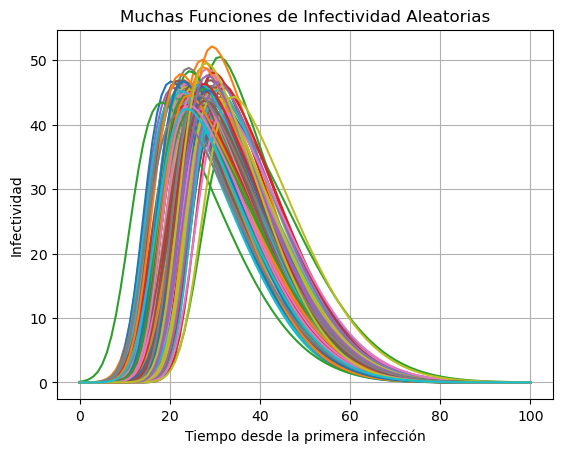

In [8]:
# Graficar varias funciones de infectividad con parámetros obtenidos de sus distribuciones correspondientes

for i in range(100):
    a = infectivity_dists["a"].rvs() # Obtener un valor para a
    m = infectivity_dists["m"].rvs() # Obtener un valor para m
    s = infectivity_dists["s"].rvs() # Obtener un valor para s
    k = infectivity_dists["k"].rvs() # Obtener un valor para k

    x_range = np.linspace(0,100,100) # Definir el rango de valores x para los cuales hacer el gráfico
    plt.plot(x_range, infectivity_func_raw(x_range, a=a, m=m, s=s, k=k)) # Calcular y graficar la función de infectividad

plt.title("Muchas Funciones de Infectividad Aleatorias")
plt.xlabel("Tiempo desde la primera infección")
plt.ylabel("Infectividad")
plt.grid()
plt.show()


#### La función distancia:

La ecuación de distancia que usamos en nuestro modelo se basa en una logística generalizada de Tipo I proveniente de la fuente [https://en.wikipedia.org/wiki/Generalized_logistic_distribution](https://en.wikipedia.org/wiki/Generalized_logistic_distribution):

$$1-\left(Qe^{-x}+1\right)^{-v}$$

Podemos visualizar esto trazando nuestra función.

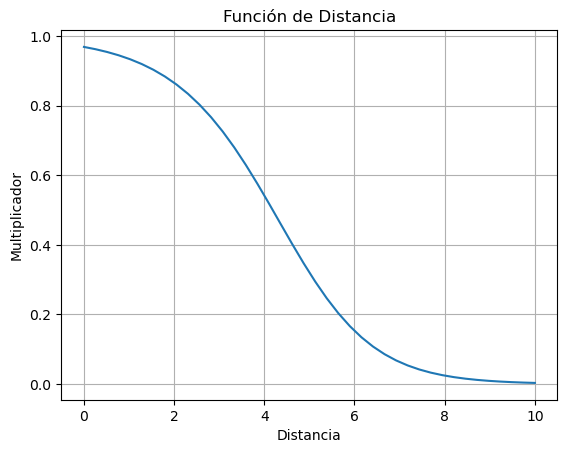

In [9]:
# Almacenar y mostrar la función en formato LaTeX para la función de distancia
# Esto se basa en una distribución logística generalizada de Tipo I de
# https://en.wikipedia.org/wiki/Generalized_logistic_distribution
# Define los símbolos utilizados en la ecuación
# Q y v son ambos parámetros que se pueden ajustar para obtener la forma deseada
# x es la variable independiente (distancia)
Q, v, x = symbols('Q, v, x')
# Reescribe la función de distancia usando Sympy
distance_form = 1-(Q*exp(-x)+1)**(-v)
# Define los parámetros para la función de distancia
distance_params = [(Q, 100), (v, 0.75)]
# Convierte la función en una función vectorizada
distance_func = lambdify(x, distance_form.subs(distance_params), "numpy")

# Graficar la función de distancia
x_range = np.linspace(0,10,40) # Define el rango de valores x para los cuales hacer el gráfico
plt.plot(x_range, distance_func(x_range)) # Calcular y graficar la función de distancia
plt.title("Función de Distancia")
plt.xlabel("Distancia")
plt.ylabel("Multiplicador")
plt.grid()
plt.show()

#### La función de exposición:

La ecuación de exposición que utilizamos en nuestro modelo se basa en una distribución logística:

$$\frac{1}{1 + e^{- k \left(x-s\right)}}$$

In [10]:
# Almacena y muestra la función Latex para la función de exposición
# Esta es una distribución logística
# Define los símbolos utilizados en la ecuación
# k es la tasa de crecimiento de la función de exposición
# s es el punto de inflexión de la función de exposición (la exposición para la cual la función tiene el aumento más pronunciado)
# x es la variable independiente (exposición)
k, s, x = symbols('k, s, x')
# Reescribe la función de exposición usando Sympy
exposure_form = 1/(1+exp(-k*(x-s)))
# Define uno de los parámetros para la función de exposición
exposure_params = [(k, .068)]
# Convierte la función en una función vectorizada
exposure_func_raw = lambdify([x, s], exposure_form.subs(exposure_params)-.007, "numpy")

exposure_sliders = {} # Define un diccionario para contener los controles deslizantes para cada parámetro
exposure_dists = {} # Define un diccionario para contener las distribuciones para cada parámetro
exposure_sliders["s"], exposure_dists["s"] = get_var_dist(100, 6, 25) # Almacena el control deslizante/distribución para s

Podemos visualizar esto trazando nuestra función.

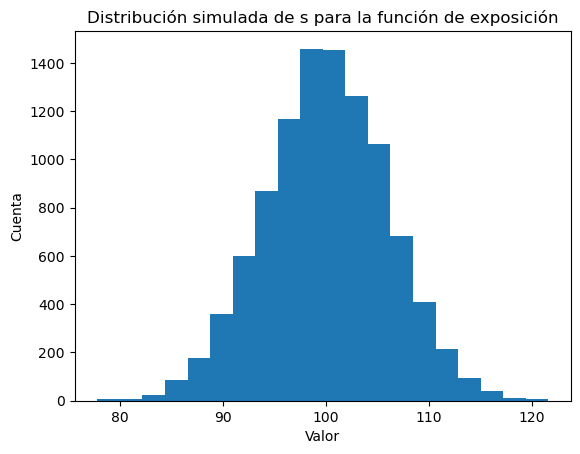

In [11]:
# Hacemos un gráfico para mostrar la distribución simulada de los parámetros en la función de exposición.

plt.hist(exposure_dists["s"].rvs(10000), bins=20)
plt.title("Distribución simulada de s para la función de exposición")
plt.xlabel("Valor")
plt.ylabel("Cuenta")
plt.show()

In [12]:
# Hacemos un gráfico interactivo para mostrar la función de expresión para diferentes valores del parámetro s

@interact(**exposure_sliders)
def plot_exposure_func(s=100):
    x_range = np.linspace(0,400,100)

    plt.plot(x_range, exposure_func_raw(x_range, s))
    plt.title("Función exposición")
    plt.xlabel("Valor de la exposioción")
    plt.ylabel("Probabilidad de enfermar")
    plt.grid()
    plt.show()

interactive(children=(FloatSlider(value=100.0, description='s', max=125.0, min=75.0, step=2.5), Output()), _do…

Creamos nuestra aleatoriedad nuevamente como lo hicimos con la infectividad:

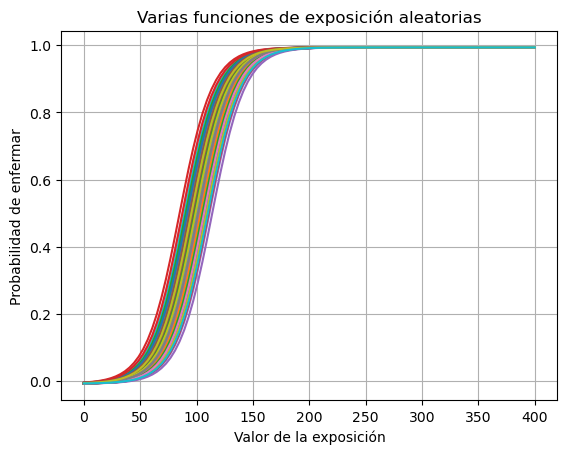

In [13]:
# Trazamos varias funciones de exposición con parámetros extraídos de sus distribuciones correspondientes.

for i in range(100):
    s = exposure_dists["s"].rvs()

    x_range = np.linspace(0,400,100)
    plt.plot(x_range, exposure_func_raw(x_range, s))

plt.title("Varias funciones de exposición aleatorias")
plt.xlabel("Valor de la exposición")
plt.ylabel("Probabilidad de enfermar")
plt.grid()
plt.show()

Para mayor comodidad, las funciones que toman parámetros aleatorizados por persona están encapsuladas de manera que, en lugar de aceptar los parámetros como argumentos, recibe un objeto persona como argumento.

In [14]:
def person_wrapper(func, params):
    ''' Ajuste una de las funciones anteriores para que pueda ser llamada con un objeto persona (y luego los parámetros para
        esa persona son recuperadas y utilizadas).

        Parámetros
        ----------
        func: función
        La función para envolver.

        params:
        Una cadena que representa el nombre del atributo que contiene los parámetros. Este atributo debe ser un diccionario.
        con los nombres de los parámetros como claves y los valores de los parámetros como valores.

        Devoluciones
        -------
        salida: función
        La función envuelta, que acepta el valor x como primer argumento y el objeto persona como segundo.
        '''

    def inner(x, person):
        return func(x, **getattr(person, params))

    return inner

In [15]:
# Ajustar las funciones de infectividad y exposición para que puedan ser llamadas con un objeto persona (en lugar de los valores
# de los propios parámetros)
infectivity_func = person_wrapper(infectivity_func_raw, "infectivity_params")
exposure_func = person_wrapper(exposure_func_raw, "exposure_params")

## Agregando nuestras clases

Ahora podemos crear nuestra clase de persona y clase de entorno y definir cómo se ejecutará la simulación. Luego hacemos que las acciones se lleven a cabo mediante métodos en el entorno, mientras que la clase persona se usa principalmente para contener atributos relacionados.

### Clase Person (Persona)

In [16]:
class Person:
    '''Una clase que representa a una persona en la simulación. Un objeto persona contiene información específica de cada persona,
      mientras que el resto de la información en el modelo basado en agentes está contenida en la clase Environment. No hay métodos
      definido en la clase Person; más bien, las acciones las lleva a cabo el medio ambiente.

    Atributos
    ----------
    location: ndarray
        La matriz 1D de longitud 2 representa la ubicación de la persona. El primer elemento es la coordenada x, y
        el segundo elemento es la coordenada y.

    speed: float
        La distancia que recorre la persona por unidad de tiempo.

    infectivity_params: dict
        Un diccionario que contiene los valores de los parámetros de la función de infectividad. Las claves son las
        nombres de parámetros y los valores son los valores de los parámetros mismos.

    exposure_params: dict
        Un diccionario que contiene los valores de los parámetros de la función de exposición. Las claves son las
        nombres de parámetros y los valores son los valores de los parámetros mismos.

    angle: float
        El ángulo con el que viaja la persona en ese momento, en radianes.

    angle_deviation: float
        El ángulo máximo en el que cambia la dirección de una persona por unidad de tiempo, en radianes.

    exposure: float
        La cantidad de exposición que la persona ha tenido a la enfermedad.

    caught_time: int (or None)
        El momento en que la persona contrajo la enfermedad por última vez. Si no han contraído la enfermedad antes, entonces el valor
        es None.

    recovered_time: int (or None)
        El momento en que la persona se recuperó por última vez de la enfermedad. Si no se han recuperado de la enfermedad antes,
        entonces el valor es None.
    '''

    def __init__(self,
                 location,
                 speed,
                 infectivity_params,
                 exposure_params):
        '''Inicializa un objeto de persona.

          Parametros
          ----------
          location: ndarray
              La matriz 1D de longitud 2 representa la ubicación de la persona. El primer elemento es la coordenada x, y
              el segundo elemento es la coordenada y.

          speed: float
              La distancia que recorre la persona por unidad de tiempo.

          infectivity_params: dict
              Un diccionario que contiene los valores de los parámetros de la función de infectividad. Las claves son las
              nombres de parámetros y los valores son los valores de los parámetros mismos.

          exposure_params: dict
              Un diccionario que contiene los valores de los parámetros de la función de exposición. Las claves son las
              nombres de parámetros y los valores son los valores de los parámetros mismos.
        '''
        args = locals().copy() # Extrae una copia de todas las variables locales como un diccionario (es decir, los argumentos de la función)
        del args["self"] # Eliminar self del diccionario
        self.__dict__.update(args) # Agrega todos estos argumentos como atributos del objeto

        self.angle = np.random.uniform(0, 2*np.pi) # Inicializa un ángulo aleatorio en el que la persona se mueve
        self.angle_deviation = .5 # Inicializa la desviación del ángulo a 0,5

        self.exposure = 0 # Inicializa la exposición a 0 (el valor mínimo)
        self.caught_time = None # Inicializa la hora en la que la persona contrajo la enfermedad por última vez en Ninguno
        self.recovered_time = None # Inicializa la hora en la que la persona se recuperó por última vez de la enfermedad en Ninguno

### La clase Environment:

In [17]:
class Environment:
    '''La clase Environment contiene parámetros que afectan a todas las personas por igual, así como los métodos para ejecutar y hacer avanzar el modelo basado en agentes.

    Atributos
    ----------
    infectivity_func: function
        La función de infectividad (recibe el objeto de una persona y el tiempo desde que se enfermó y devuelve la
        cantidad de exposición para contribuir a los agentes susceptibles vecinos).

    distance_func: function
        La función de distancia (recibe la distancia como argumento y devolviendo la proporción de la exposición que el
        persona realmente recibe).

    exposure_func: function
        La función de exposición (recibe el nivel de exposición y un objeto persona como argumentos y devolviendo la probabilidad
        que la persona contraiga la enfermedad en ese momento).

    infectivity_dists: dict
        Las distribuciones de los parámetros de la función de infectividad. Las claves deben ser cadenas que representen el nombre.
        del parámetro, y los valores deben ser distribuciones del tipo rv_frozen.

    exposure_dists: dict
        Las distribuciones de los parámetros de la función de exposición. Las claves deben ser cadenas que representen el nombre de
        el parámetro y los valores deben ser distribuciones del tipo rv_frozen.

    radius: float
        El radio dentro de la transmisión es posible.

    shape: ndarray
        Las dimensiones del entorno como una matriz 1D de longitud dos. El primer elemento es el ancho y el segundo es el largo.

    speed: float
        La velocidad de las personas en la simulación.

    immunity_time: int
        El período de tiempo que una persona es inmune a la enfermedad después de recuperarse.

    exposure_decrement: float
        La cantidad en la que la exposición de una persona disminuye cada unidad de tiempo.

    permanent_immunity: bool
        Si es True, los agentes quedan permanentemente inmunes después de recuperarse de la enfermedad. Si es False, los agentes enfermarse varias veces.

    is_death: bool
        Si es True, los agentes infectados tienen posibilidades de morir. Si es False, no se incorpora ninguna muerte al modelo.

    death_prob: float
        La probabilidad de que un agente infectado muera en cualquier momento.

    people: dict
        Un diccionario que contiene los agentes. Las claves son el grupo en el que se encuentran los agentes, que es "S" para
        susceptible, "I" para infectado, "R" para recuperado o "D" para muerto. Los valores son listas de objetos Person.

    time: int
        El tiempo actual en la simulación (aumenta en 1 en cada paso).

    Metodos
    -------
    add_person: Agrega una persona a la simulación.

    advance_time: Avanza la simulación un paso en el tiempo y se obtienen matrices de las ubicaciones de cada persona.
    '''

    def __init__(self,
                 infectivity_func=infectivity_func,
                 distance_func=distance_func,
                 exposure_func=exposure_func,
                 infectivity_dists=infectivity_dists,
                 exposure_dists=exposure_dists,
                 radius=8,
                 shape=np.array([100,100]),
                 speed=1,
                 immunity_time=60,
                 exposure_decrement=15,
                 permanent_immunity=True,
                 is_death=False,
                 death_prob=0.0002):

        '''Inicializar el objeto Environment.

        Parametros
        ----------

        infectivity_func: function
            La función de infectividad (recibe el objeto de una persona y el tiempo desde que se enfermó y devuelve la
            cantidad de exposición para contribuir a los agentes susceptibles vecinos).

        distance_func: function
            La función de distancia (recibe la distancia como argumento y devolviendo la proporción de la exposición que el
            persona realmente recibe).

        exposure_func: function
            La función de exposición (recibe el nivel de exposición y un objeto persona como argumentos y devolviendo la probabilidad
            que la persona contraiga la enfermedad en ese momento).

        infectivity_dists: dict
            Las distribuciones de los parámetros de la función de infectividad. Las claves deben ser cadenas que representen el nombre.
            del parámetro, y los valores deben ser distribuciones del tipo rv_frozen.

        exposure_dists: dict
            Las distribuciones de los parámetros de la función de exposición. Las claves deben ser cadenas que representen el nombre de
            el parámetro y los valores deben ser distribuciones del tipo rv_frozen.

        radius: float
            El radio dentro de la transmisión es posible.

        shape: ndarray
            Las dimensiones del entorno como una matriz 1D de longitud dos. El primer elemento es el ancho y el segundo es el largo.

        speed: float
            La velocidad de las personas en la simulación.

        immunity_time: int
            El período de tiempo que una persona es inmune a la enfermedad después de recuperarse.

        exposure_decrement: float
            La cantidad en la que la exposición de una persona disminuye cada unidad de tiempo.

        permanent_immunity: bool
            Si es True, los agentes quedan permanentemente inmunes después de recuperarse de la enfermedad. Si es False, los agentes enfermarse varias veces.

        is_death: bool
            Si es True, los agentes infectados tienen posibilidades de morir. Si es False, no se incorpora ninguna muerte al modelo.

        death_prob: float
            La probabilidad de que un agente infectado muera en cualquier momento.

        '''

        args = locals().copy() # Extrae una copia de todas las variables locales como un diccionario (es decir, los argumentos de la función)
        del args["self"] # Eliminar self del diccionario
        self.__dict__.update(args) # Agreguar todos estos argumentos como atributos del objeto.

        self.people = {"S": [], "I": [], "R": [], "D": []} # Inicializar un diccionario para alojar a las agentes por grupo.
        self.time = 0 # Inicializar el tiempo a 0

    def _gen_location(self):
        '''Genera una ubicación aleatoria dentro del entorno.

        Parametros
        ----------
        None

        Retorna
        -------
        output: ndarray
            Una ubicación como una matriz 1D de longitud 2, donde el primer elemento es la coordenada x y el segundo elemento
            es la coordenada y.
        '''

        return np.random.uniform(self.shape)

    def _gen_params(self):
        '''Genera parámetros aleatorios para las funciones de infectividad y exposición..

        Parametros
        ----------
        None

        Retorna
        -------
        output: dict
            Un diccionario que contiene las claves "infectivity_params" y "exposure_params" y los valores como diccionarios.
            que contiene los valores de los parámetros (las claves son los nombres de los parámetros y los valores son los valores del
            parámetros).
        '''

        # Inicializar el diccionario de parámetros para la función de infectividad mediante la comprensión del diccionario
        infectivity_params = {key:dist.rvs() for key,dist in infectivity_dists.items()}
        # Inicializar el diccionario de parámetros para la función de exposición mediante comprensión del diccionario.
        exposure_params = {key:dist.rvs() for key,dist in exposure_dists.items()}
        return {"infectivity_params": infectivity_params, "exposure_params": exposure_params}

    def add_person(self, group="S"):
        '''Añade una persona al entorno.

        Parametros
        ----------
        group: str
            El grupo al que se agrega la persona. Debe ser uno de "S" para susceptible, "I" para infectado,
            "R" para recuperado, o "D" para muerto. El valor predeterminado es "S".

        Retorna
        -------
        None
        '''

        # Inicialice a la persona con una ubicación aleatoria, la velocidad especificada en el entorno y una ubicación aleatoria.
        # parámetros para las funciones de infectividad y exposición
        person = Person(location = self._gen_location(), speed = self.speed, **self._gen_params())

        # Inicializa caught_time y recovered_time a 0 si es necesario
        if group=="I":
            person.caught_time = 0
        elif group=="R":
            person.recovered_time = 0

        self.people[group].append(person) # Agrega a la persona a la lista correspondiente.

    def _move_all(self):
        '''Mueve todos los agentes en la simulación.

        Parametros
        ----------
        None

        Retorno
        -------
        None
        '''

        for group in self.people.values(): # Recorre todos los grupos de personas.
            for person in group: # Recorre las personas dentro de cada grupo.
                # Modificar el ángulo en una cantidad aleatoria a partir de una distribución uniforme
                person.angle += np.random.uniform(-person.angle_deviation, person.angle_deviation)
                # Calcular el vector de desplazamiento de longitud dado por su velocidad y dirección dada por su ángulo
                vector = person.speed*np.array([np.cos(person.angle), np.sin(person.angle)])
                # Actualizar su ubicación, haciendo que se ajusten a los bordes si es necesario
                person.location = np.mod(person.location+vector, self.shape)

    def _infected_actions(self):
        '''Realice todas las acciones necesarias sobre la población infectada en un solo paso de tiempo. En concreto,
          las personas infectadas se recuperan o infectan a sus vecinos. Luego, si todavía están infectados, es posible que tengan
          una posibilidad de morir.

        Parametros
        ----------
        None

        Retornos
        -------
        None
        '''

        # Recorra la lista de personas infectadas por índice a la inversa (ya que la lista puede modificarse)
        idx = len(self.people["I"])-1
        while idx >= 0:
            infected = self.people["I"][idx] # Acceder a la persona en el índice actual
            time_since_caught = self.time - infected.caught_time # Calcular el tiempo que la persona ha estado infectada
            infectivity = self.infectivity_func(time_since_caught, infected) # Calcular la infectividad de la persona.

             # Si la infectividad es baja (y supera el pico), entonces la persona se recupera
            if time_since_caught>40 and infectivity<1:
                del self.people["I"][idx] # Eliminar a la persona de la lista de infectados
                self.people["R"].append(infected) # Agregar a la persona a la lista recuperada
                infected.recovered_time = self.time # Establecer la hora recuperada a la hora actual
            else:
                for person in self.people["S"]: # Recorrer todos los agentes susceptibles
                    # Encuentre el vector más corto que conecta a las dos personas (permitido abarcar los bordes)
                    vector = np.abs(person.location - infected.location)
                    wrapped_vector = np.minimum(vector, self.shape-vector)
                    distance = np.linalg.norm(wrapped_vector, ord=2) # Calcular la distancia entre las dos personas.
                    # Si la distancia es menor que el radio, aumente la exposición de la persona.
                    if distance <= self.radius:
                        person.exposure += infectivity*self.distance_func(distance)
            # Si la muerte es un factor en el modelo, use un número aleatorio para ver si la persona muere
            if self.is_death and np.random.random() < self.death_prob:
                del self.people["I"][idx] # Eliminar a la persona de la lista de infectados
                self.people["D"].append(infected) # Agregar la persona a la lista de muertos
            idx -= 1 # Disminuir el índice

    def _susceptible_actions(self):
        '''Realice todas las acciones necesarias en la población susceptible durante un solo paso de tiempo. Específicamente,
            susceptibles contraen la enfermedad o ven reducida su exposición.

        Parametros
        ----------
        None

        Retorno
        -------
        None
        '''

        # Recorra la lista de personas susceptibles por índice a la inversa (ya que la lista puede modificarse)
        idx = len(self.people["S"])-1
        while idx >= 0:
            susceptible = self.people["S"][idx] # Accede a la persona en el índice actual
            # Comprobar si la persona contrae la enfermedad utilizando la función de exposición.
            if np.random.random() < self.exposure_func(susceptible.exposure, susceptible):
                del self.people["S"][idx] # Eliminar a la persona de la lista de susceptibles
                self.people["I"].append(susceptible) # Agregar la persona a la lista de infectados
                susceptible.caught_time = self.time
            else:
                # Disminuir la exposición de la persona (sin bajar de 0)
                susceptible.exposure = max(susceptible.exposure-self.exposure_decrement, 0)
            idx -= 1 # Disminuir el índice

    def _recovered_actions(self):
        '''Realiza todas las acciones necesarias sobre la población recuperada en un solo paso de tiempo. Específicamente,
          las personas recuperadas pueden volver a ser susceptibles si su período de inmunidad ha terminado (y la inmunidad permanente
          es False).

        Parametros
        ----------
        None

        Retorno
        -------
        None
        '''

        # Se ejecuta el siguiente código solo si es posible volver a contraer la enfermedad
        if not self.permanent_immunity:
            # Recorra la lista de personas recuperadas por índice a la inversa (ya que la lista puede modificarse)
            idx = len(self.people["R"])-1
            while idx>= 0:
                recovered = self.people["R"][idx] # Acceder a la persona en el índice actual
                # Se comprueba si la inmunidad de la persona recuperada ha finalizado
                if self.time > recovered.recovered_time+self.immunity_time:
                    del self.people["R"][idx] # Eliminar a la persona de la lista recuperada
                    self.people["S"].append(recovered) # Agregar la persona a la lista de susceptibles
                    recovered.exposure = 0 # Restablecer la exposición a 0
                idx -= 1 # Disminuir el índice

    def _get_location_arrays(self):
        '''Obtener matrices que representen la ubicación de las personas de cada grupo, excluyendo a los muertos.

        Parametros
        ----------
        None

        Retorno
        -------
        output: list
            Una lista de conjuntos de ubicaciones de las personas, donde el primer elemento es la población susceptible,
            el segundo es la población infectada y el tercero es la población recuperada. Cada matriz tiene
            dos columnas, donde la primera columna son las coordenadas x de las personas y la segunda columna es la
            coordenadas y.
        '''

        return [np.array([person.location for person in group]) for group_name, group in self.people.items() if group_name != "D"]

    def advance_time(self):
        '''Avanzar el tiempo de la simulación.

        Parametros
        ----------
        None

        Retorno
        -------
        output: list
            Una lista de conjuntos de ubicaciones de las personas, donde el primer elemento es la población susceptible,
            el segundo es la población infectada y el tercero es la población recuperada. Cada matriz tiene
            dos columnas, donde la primera columna son las coordenadas x de las personas y la segunda columna es la
            coordenadas y.
        '''
        self.time += 1 # Incrementar el tiempo
        self._move_all() # Mover a todos los agentes

        self._infected_actions() # Realizar acciones a infectados
        self._susceptible_actions() # Realizar acciones a susceptibles
        self._recovered_actions() # Realizar acciones a recuperados

        return self._get_location_arrays()

Una vez que tenemos nuestras clases ordenadas, introducimos semillas específicas para que podamos obtener reproducibilidad e inicializar un entorno completamente nuevo con sus "personas". Luego agregamos un agente infectado entre ellos.

## Ejecutando el experimento

El siguiente código ejecuta el modelo y grafica el resultado.

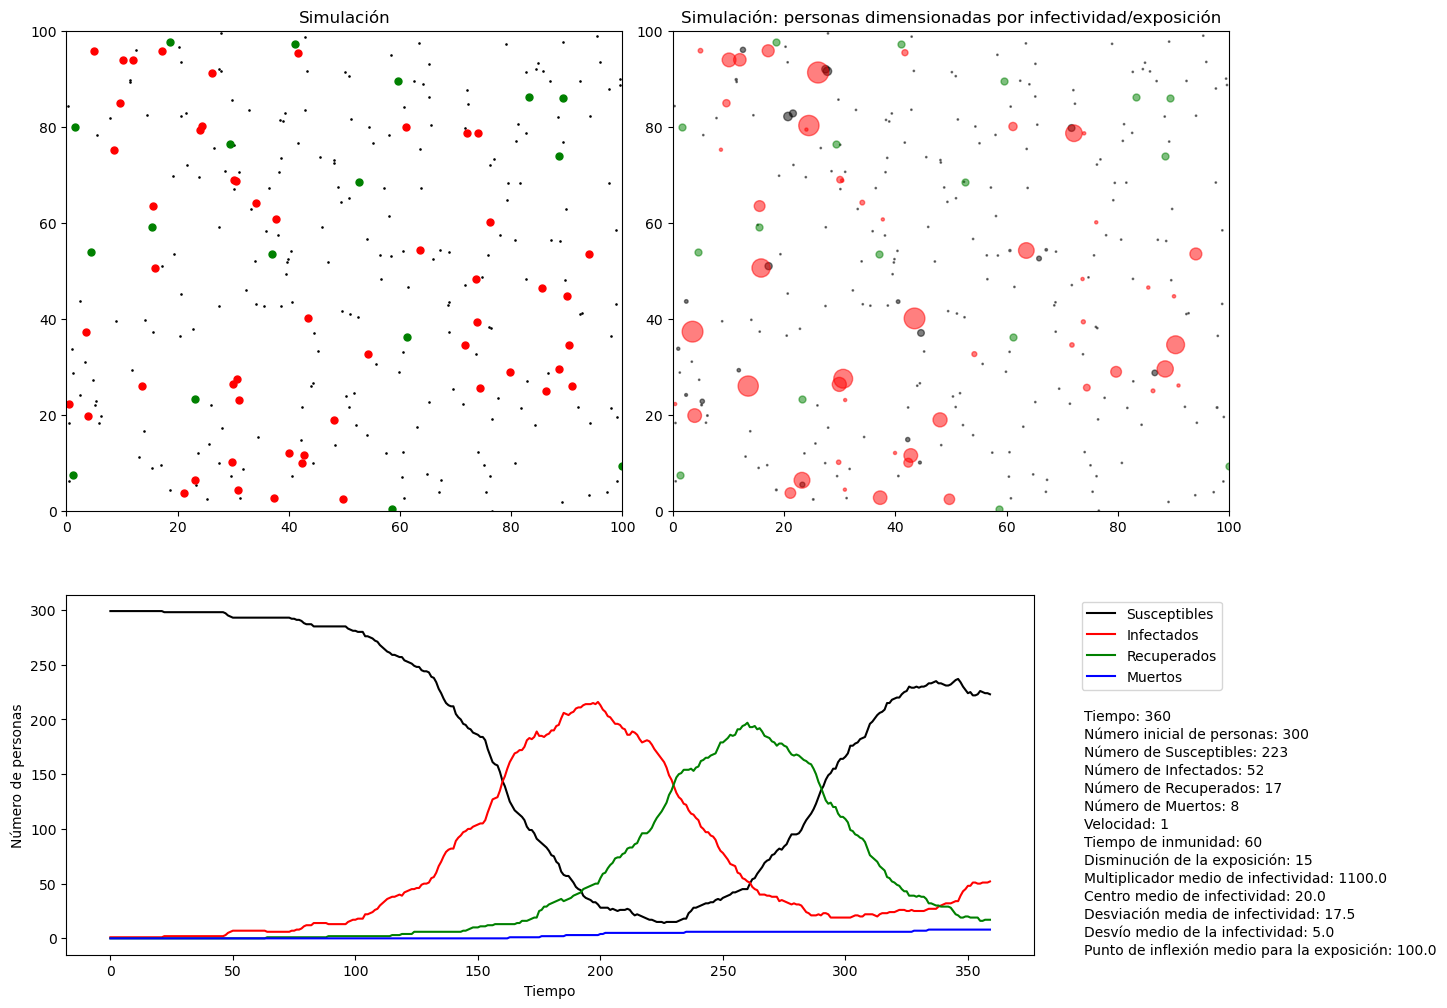

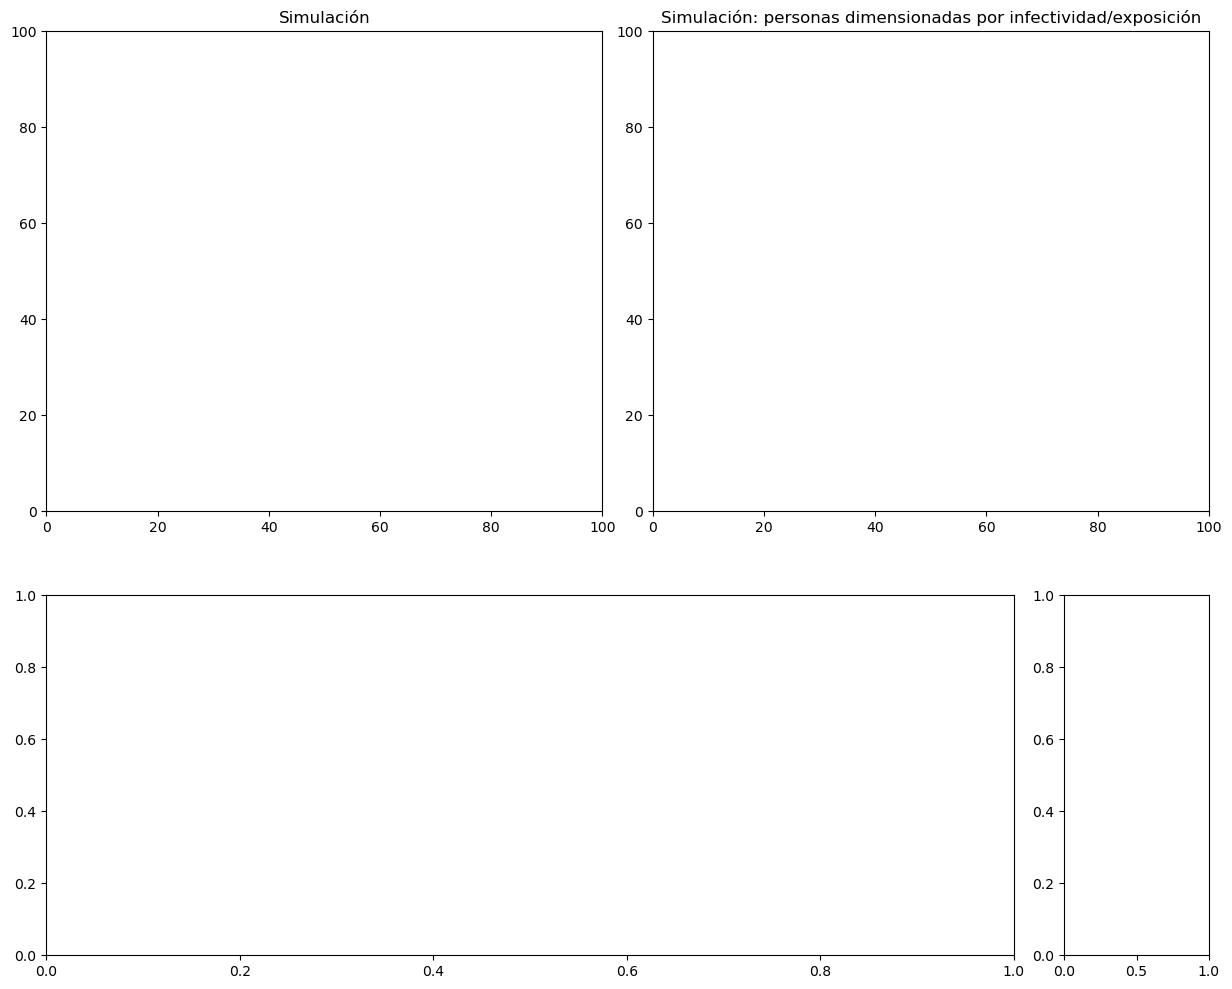

In [18]:
import time

np.random.seed(31415) # Establecer una semilla aleatoria para la reproducibilidad

# Inicializar el entorno
env = Environment(permanent_immunity=False, exposure_decrement=15, is_death=True)

# Agregar agentes susceptibles
for _ in range(299):
    env.add_person()

# Agregar un agente infectado
env.add_person("I")

fig = plt.figure(figsize=(15,12)) # Inicializar una figura
gs = GridSpec(2,4, figure=fig, height_ratios=[4,3], width_ratios=[5,2,5,2]) # Especificar las subtramas con GridSpec
ax_sim1 = fig.add_subplot(gs[0,:2]) # Inicializar el panel de simulación principal
# Establecer los límites en el panel principal de simulación
ax_sim1.set_xlim(0,env.shape[0])
ax_sim1.set_ylim(0,env.shape[1])

ax_sim2 = fig.add_subplot(gs[0,2:]) # Inicializar el panel de simulación secundario
# Establecer los límites en el panel de simulación secundario
ax_sim2.set_xlim(0,env.shape[0])
ax_sim2.set_ylim(0,env.shape[1])

ax_infected = fig.add_subplot(gs[1,:-1]) # Inicialice un conjunto de ejes para un gráfico de líneas del tamaño de los grupos.
ax_info = fig.add_subplot(gs[1,-1]) # Inicializar un conjunto de ejes para información textual.

# Inicializar listas para contener la cantidad de personas en cada grupo en cada momento
num_s = []
num_i = []
num_r = []
num_d = []

start_time = time.time()

num_days = 360


for day in range(num_days):


    S_locs, I_locs, R_locs = env.advance_time() # Avanzar el tiempo y almacenar las ubicaciones de cada grupo
    # Corregir las dimensiones de los arrays en el caso de que un grupo esté vacío
    if not S_locs.size:
        S_locs = np.empty(shape=(0,2))
    if not I_locs.size:
        I_locs = np.empty(shape=(0,2))
    if not R_locs.size:
        R_locs = np.empty(shape=(0,2))

    S_plot1 = ax_sim1.scatter(*S_locs.T, c="k", marker=".", s=3) # Mostrar la población susceptible en negro.
    R_plot1 = ax_sim1.scatter(*R_locs.T, c="g", marker=".", s=100) # Mostrar en verde la población recuperada.
    I_plot1 = ax_sim1.scatter(*I_locs.T, marker=".", s=100, c="r") # Mostrar en rojo la población infestada.

    ax_sim1.set_title("Simulación") # Establecer el título del panel de simulación principal

    # Inicialice una lista que represente el tamaño de cada persona infectada (según su infectividad)
    I_size = np.array([env.infectivity_func(env.time - person.caught_time, person) for person in env.people["I"]])+1
    # Inicializar una lista que represente el tamaño de cada persona susceptible (según su exposición)
    S_size = np.array([person.exposure for person in env.people["S"]])+2
    S_plot2 = ax_sim2.scatter(*S_locs.T, c="k", marker=".", s=S_size*2, alpha=.5) # Plot la población susceptible
    R_plot2 = ax_sim2.scatter(*R_locs.T, c="g", marker=".", s=100, alpha=.5) # Plot la poblacion recuperada
    I_plot2 = ax_sim2.scatter(*I_locs.T, marker=".", s=I_size*20, c="r", alpha=.5) # Plot la población infectada

    ax_sim2.set_title("Simulación: personas dimensionadas por infectividad/exposición") # Establecer el título del panel de simulación secundario

    # Actualizar las listas con el tamaño actual de cada grupo.
    num_s.append(len(env.people["S"]))
    num_i.append(len(env.people["I"]))
    num_r.append(len(env.people["R"]))
    num_d.append(len(env.people["D"]))

    ax_infected.plot(num_s, color="k", label="Susceptibles") # Plot el número de personas susceptibles a lo largo del tiempo
    ax_infected.plot(num_i, color="r", label="Infectados") # Plot el número de personas infectadas a lo largo del tiempo
    ax_infected.plot(num_r, color="g", label="Recuperados") # Plot el número de personas recuperadas a lo largo del tiempo
    if env.is_death:
        ax_infected.plot(num_d, color="b", label="Muertos") # Plot el número de muertos a lo largo del tiempo

    ax_infected.set_xlabel("Tiempo") # Establecer la etiqueta x del gráfico lineal
    ax_infected.set_ylabel("Número de personas") # Establecer la etiqueta y del gráfico lineal

    ax_info.legend(*ax_infected.get_legend_handles_labels()) # Agregar una leyenda (en una subtrama diferente, de ahí el argumento)
    ax_info.axis('off') # Eliminar los ejes de la subtrama de texto.

    if env.is_death: # Mostrar texto en el caso de que la muerte sea parte del modelo.
        ax_info.text(0,.65,"Tiempo: "+str(env.time),size=10)
        ax_info.text(0,.6,"Número inicial de personas: "+str(num_s[-1]+num_i[-1]+num_r[-1]+num_d[-1]),size=10)
        ax_info.text(0,.55,"Número de Susceptibles: "+str(num_s[-1]),size=10)
        ax_info.text(0,.5,"Número de Infectados: "+str(num_i[-1]),size=10)
        ax_info.text(0,.45,"Número de Recuperados: "+str(num_r[-1]),size=10)
        ax_info.text(0,.4,"Número de Muertos: "+str(num_d[-1]),size=10)
        ax_info.text(0,.35,"Velocidad: "+str(env.speed),size=10)
        ax_info.text(0,.3,"Tiempo de inmunidad: "+("inf" if env.permanent_immunity else str(env.immunity_time)),size=10)
        ax_info.text(0,.25,"Disminución de la exposición: "+str(env.exposure_decrement),size=10)
        ax_info.text(0,.2,"Multiplicador medio de infectividad: "+str(env.infectivity_dists["a"].mean()),size=10)
        ax_info.text(0,.15,"Centro medio de infectividad: "+str(env.infectivity_dists["m"].mean()),size=10)
        ax_info.text(0,.1,"Desviación media de infectividad: "+str(env.infectivity_dists["s"].mean()),size=10)
        ax_info.text(0,.05,"Desvío medio de la infectividad: "+str(env.infectivity_dists["k"].mean()),size=10)
        ax_info.text(0,.0,"Punto de inflexión medio para la exposición: "+str(env.exposure_dists["s"].mean()),size=10)
    else: # Mostrar texto en el caso de que la muerte no sea parte del modelo.
        ax_info.text(0,.7,"Tiempo: "+str(env.time),size=10)
        ax_info.text(0,.65,"Total de personas: "+str(num_s[-1]+num_i[-1]+num_r[-1]),size=10)
        ax_info.text(0,.6,"Número de Susceptibles: "+str(num_s[-1]),size=10)
        ax_info.text(0,.55,"Número de Infectados: "+str(num_i[-1]),size=10)
        ax_info.text(0,.5,"Número de Recuperados: "+str(num_r[-1]),size=10)
        ax_info.text(0,.45,"Velocidad: "+str(env.speed),size=10)
        ax_info.text(0,.4,"Tiempo de inmunidad: "+("inf" if env.permanent_immunity else str(env.immunity_time)),size=10)
        ax_info.text(0,.35,"Disminución de la exposición: "+str(env.exposure_decrement),size=10)
        ax_info.text(0,.3,"Multiplicador medio de infectividad: "+str(env.infectivity_dists["a"].mean()),size=10)
        ax_info.text(0,.25,"Centro medio de infectividad: "+str(env.infectivity_dists["m"].mean()),size=10)
        ax_info.text(0,.2,"Desviación media de infectividad: "+str(env.infectivity_dists["s"].mean()),size=10)
        ax_info.text(0,.15,"Desvío medio de la infectividad: "+str(env.infectivity_dists["k"].mean()),size=10)
        ax_info.text(0,.1,"Punto de inflexión medio para la exposición: "+str(env.exposure_dists["s"].mean()),size=10)

    clear_output(wait=True) # Borrar la salida
    display(fig) # Mostrar el modelo
    #plt.savefig("output/output"+str(env.time)) # Guarde el gráfico en la carpeta "output"
    I_plot1.remove() # Eliminar agentes infectados de la simulación principal.
    S_plot1.remove() # Eliminar agentes susceptibles de la simulación principal.
    R_plot1.remove() # Eliminar agentes recuperados de la simulación principal.
    I_plot2.remove() # Eliminar agentes infectados de la simulación secundaria.
    S_plot2.remove() # Eliminar agentes susceptibles de la simulación secundaria.
    R_plot2.remove() # Eliminar agentes recuperados de la simulación secundaria.
    ax_infected.cla() # Limpiar el plot de líneas
    ax_info.cla() # Borrar el texto informativo

## Resultados

## El modelo SIR

### SIR Básico

Creamos un modelo SIR básico y probamos diferentes valores de los parámetros para ver los posibles resultados cualitativos.

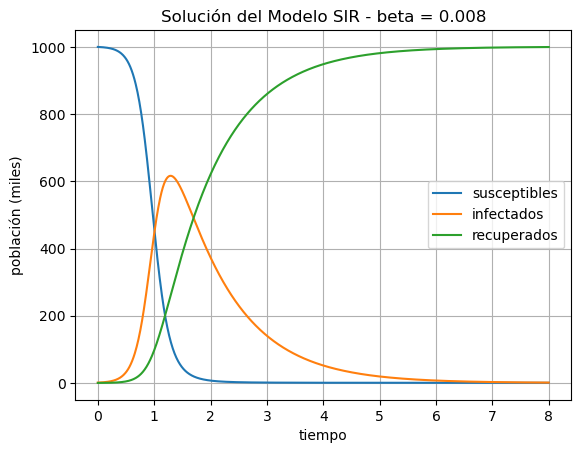

In [19]:
# Modelo SIR
def SIR(time, current_state, beta, gamma):
    susceptible = current_state[0]
    infectious = current_state[1]
    recovered = current_state[2]
    susceptible_dot = -beta*susceptible*infectious
    infectious_dot = beta*susceptible*infectious - gamma*infectious
    recovered_dot = gamma*infectious
    return [susceptible_dot, infectious_dot, recovered_dot]

beta = 0.008
gamma = 1
initial_conditions = [1000,1,0]
time = np.linspace(0,8,1000)
result = solve_ivp(SIR, (0,8), initial_conditions, t_eval = time, args=(beta, gamma))
susceptible = result.y[0,:]
infectious = result.y[1,:]
recovered = result.y[2,:]
plt.plot(time, susceptible, label='susceptibles')
plt.plot(time, infectious, label='infectados')
plt.plot(time, recovered, label='recuperados')
plt.grid()
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('población (miles)')
plt.title('Solución del Modelo SIR - beta = 0.008')
plt.show()

Para ahorrar espacio, podemos compilar los resultados de tres modelos, cada uno con diferentes parámetros, utilizando el mismo bloque de código anterior en una celda.

#### Cual es la diferencia?

El modelo SIR predice varios resultados similares:
- Todos contraen la enfermedad.
- Un subconjunto de la población que contrae la enfermedad.
- La enfermedad está desapareciendo.

A diferencia del ABM, el modelo SIR ha sesgado las curvas infectadas. Cuando la enfermedad desaparezca, el modelo SIR predice que disminuirá estrictamente, mientras que el ABM sugiere que puede permanecer constante por un tiempo.

### Reinfección SIR

Agregamos ahora la posibilidad de reinfección como hicimos con el ABM:

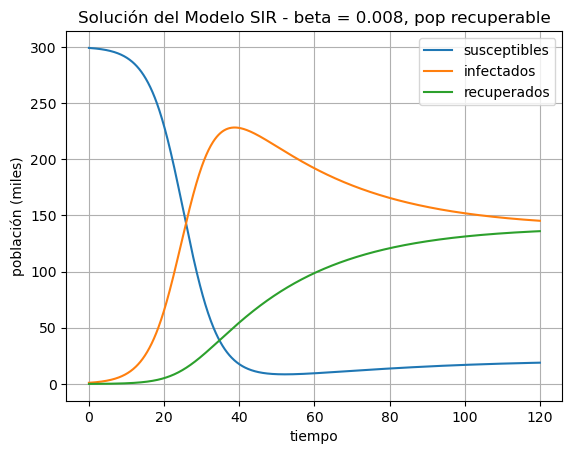

In [20]:
# Modelo SIR
def SIR(time, current_state, beta, gamma, alpha):
    susceptible = current_state[0]
    infectious = current_state[1]
    recovered = current_state[2]
    susceptible_dot = -beta*susceptible*infectious + alpha*recovered
    infectious_dot = beta*susceptible*infectious - gamma*infectious
    recovered_dot = gamma*infectious - alpha*recovered
    return [susceptible_dot, infectious_dot, recovered_dot]
#beta = 0.002
beta = 0.0008
gamma = 1/60 # Tiempo de recuperación / cuántas personas se recuperan
alpha = 1/60
initial_conditions = [299,1,0]
time = np.linspace(0,120,1000)
result = solve_ivp(SIR, (0,120), initial_conditions, t_eval = time, args=(beta, gamma, alpha))
susceptible = result.y[0,:]
infectious = result.y[1,:]
recovered = result.y[2,:]
plt.plot(time, susceptible, label='susceptibles')
plt.plot(time, infectious, label='infectados')
plt.plot(time, recovered, label='recuperados')
plt.grid()
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('población (miles)')
plt.title('Solución del Modelo SIR - beta = 0.008, pop recuperable')
plt.show()

#### ¿Qué vemos?

A diferencia del modelo ABM, el modelo SIR alcanza un equilibrio sin oscilación. Explicamos esto por el hecho de que el modelo SIR utiliza las poblaciones actuales para determinar las tarifas, mientras que en la realidad (y en el ABM), hay retrasos fijos (como el tiempo que lleva recuperarse), lo que hace que las tarifas dependan de factores anteriores. valores de las poblaciones.


# Simulación con Agentes inteligentes.


En la simulación siguiente se utilizan agentes inteligentes para modelar la propagación de un virus en un entorno determinado. La simulación involucra tres clases principales: AIController, Person y Environment.

La clase AIController se encarga de controlar el comportamiento de los agentes inteligentes en la simulación. Los parámetros de inicialización incluyen el número de personas, el radio de interacción, la forma del entorno, la estrategia de comportamiento (que puede ser "random", "social" o "awareness"), entre otros. Cada agente tiene cierto nivel de aleatoriedad en sus decisiones, tolerancia a la proximidad de otras personas, conciencia del riesgo, entre otros atributos.

La clase Person representa a cada individuo en la simulación. Cada persona tiene una ubicación, velocidad, parámetros de infectividad y exposición al virus, entre otros atributos. Además, cada persona está asociada a un controlador AI que determina su comportamiento en la simulación.

Por último, la clase Environment modela el entorno en el que se desarrolla la simulación. Se definen funciones para calcular la infectividad, distancia y exposición al virus, así como parámetros relacionados con la propagación del virus. El entorno también incluye información sobre la inmunidad temporal, probabilidad de muerte por el virus y estrategia AI a nivel global.


## Estrategias de la IA

Se han definido tres estrategias principales para los agentes inteligentes (IA) que modelan la propagación de un virus: "random", "social" y "awareness". Cada estrategia tiene un enfoque diferente en términos de cómo los agentes toman decisiones y se comportan en el entorno simulado. Aquí hay una descripción de cada una de las estrategias:

### Estrategia "Random":

En esta estrategia, los agentes toman decisiones de forma aleatoria sin considerar factores específicos del entorno o de otros agentes.
La dirección y velocidad de movimiento de los agentes son determinadas al azar, lo que puede resultar en interacciones impredecibles con otros individuos.
Esta estrategia puede simular comportamientos caóticos o poco predecibles en la propagación del virus.

### Estrategia "Social":

En esta estrategia, los agentes evitan el contacto con otras personas ajustandos su dirección y velocidad basándose en la presencia y comportamiento de otros individuos cercanos.Se espera que esta estrategia refleje comportamientos más realistas relacionados con la interacción social en la propagación del virus.

### Estrategia "Awareness":

En esta estrategia, los agentes tienen conciencia del riesgo asociado con la propagación del virus y ajustan su comportamiento en consecuencia.
La conciencia del riesgo puede influir en las decisiones de movimiento de los agentes, priorizando acciones más cautelosas cuando perciben un mayor peligro.
Esta estrategia simula un escenario donde los individuos son conscientes de las implicaciones del virus y actúan para minimizar su exposición y propagación.

Cada estrategia tiene sus propias ventajas y desventajas en términos de modelar diferentes aspectos del comportamiento humano durante una pandemia. Al implementar estas estrategias en la simulación con agentes inteligentes, se pueden explorar diversos escenarios y analizar cómo afectan a la propagación del virus y a las medidas preventivas tomadas por los individuos.

## Función de Conciencia

La función de conciencia en el contexto de la simulación es un componente importante que influye en las decisiones de los agentes inteligentes en relación con la propagación del virus. Esta función se utiliza para determinar el nivel de conciencia de un agente en función de varios factores, como la percepción del riesgo y la cantidad de individuos infectados o expuestos en su entorno.

### Bases Matemáticas

La base matemática principal de esta función es la **distribución logarítmica**, utilizada en la forma `log(1 + x)`, que se usa comúnmente para modelar fenómenos de crecimiento donde el aumento inicial es rápido, pero se desacelera a medida que `x` aumenta. Esto es apropiado para modelar la conciencia pública, ya que la percepción del riesgo (conciencia) inicialmente aumenta rápidamente con un pequeño número de casos, pero se desacelera a medida que la proporción de casos en la población aumenta.

La **función logarítmica modificada** `log(1 + x)` normalizada es la base matemática de la función de conciencia, escalada y limitada por `max_value`. Esto permite capturar el comportamiento deseado de la conciencia pública en respuesta a la epidemia, reflejando una percepción de riesgo que se estabiliza con altos números de casos.

$$\text{conciencia} = \text{maximo} \times \frac{\log(1 + \text({(infestados + fallecidos) * riesgo / poblacion}) \times \text{ajuste})}{\log(1 + \text{ajuste})}$$

### Pasos clave en la función awareness_func:

1. Se calcula el total de la población considerando los individuos en diferentes estados (infectados, recuperados, susceptibles, etc.).
2. Se calcula un valor combinado que tiene en cuenta la cantidad de individuos infectados y recuperados multiplicado por la percepción del riesgo (risk_perception).
3. Se escala este valor combinado dividiéndolo por el total de la población para obtener una medida relativa.
4. Se aplica una transformación logarítmica normalizada a este valor escalado para calcular el nivel de conciencia (awareness) del agente.
El nivel de conciencia se ajusta dentro del rango definido por max_awareness.

La función de conciencia toma en cuenta la percepción del riesgo basada en el estado de los individuos en el entorno y calcula un nivel de conciencia que guía las decisiones cautelosas o aleatorias de los agentes en función de su conciencia sobre la situación actual de propagación del virus. Esta función ayuda a modelar cómo los agentes responden a la información disponible y ajustan su comportamiento para minimizar el riesgo individual y colectivo.

In [21]:
from sympy import symbols, log
from sympy import lambdify
import numpy as np
from scipy.stats import truncnorm
from ipywidgets import FloatSlider

# Definir los símbolos utilizados en la función de conciencia
num_infected, num_deaths, total_population, risk_perception, adjustment_rate, max_value = symbols("num_infected num_deaths total_population risk_perception adjustment_rate max_value")

# Reescribir la función de conciencia usando Sympy
combined_value = (num_infected + num_deaths) * risk_perception
scaled_value = combined_value / total_population
awareness_form = max_value * log(1 + scaled_value * adjustment_rate) / log(1 + adjustment_rate)

# Convertir la función en una función vectorizada
awareness_func_raw = lambdify([num_infected, num_deaths, total_population, risk_perception, adjustment_rate, max_value], awareness_form, modules=['numpy'])

# Definición de get_var_dist
def get_var_dist(mean, sd, maxdev):
    minval = mean - maxdev
    maxval = mean + maxdev
    slider = FloatSlider(min=minval, max=maxval, step=(maxval-minval)/20, value=mean)
    dist = truncnorm(-maxdev/sd, maxdev/sd, loc=mean, scale=sd)
    return slider, dist

# Definir los sliders y las distribuciones para los parámetros de la función de conciencia
awareness_sliders = {}
awareness_dists = {}

awareness_sliders["risk_perception"], awareness_dists["risk_perception"] = get_var_dist(1.0, 0.2, 0.5)
awareness_sliders["adjustment_rate"], awareness_dists["adjustment_rate"] = get_var_dist(1.0, 0.2, 0.5)
awareness_sliders["max_value"], awareness_dists["max_value"] = get_var_dist(0.9, 0.1, 0.2)


Podemos visualizar las distribuciones de los parámetros posibles trazando histogramas:

In [22]:
import matplotlib.pyplot as plt
from ipywidgets import interact


@interact(variable=awareness_sliders.keys())
def plot_dists(variable):
    '''Trazar un histograma simulado de la distribución para un parámetro de la función de conciencia.

    Parámetros
    ----------
    variable: str
        Uno de los nombres en el diccionario awareness_sliders.

    Retorna
    -------
    None
    '''

    plt.hist(awareness_dists[variable].rvs(10000), bins=20)
    plt.title("Distribución Simulada de Variables de Conciencia")
    plt.xlabel("Valor")
    plt.ylabel("Recuento")
    plt.show()

interactive(children=(Dropdown(description='variable', options=('risk_perception', 'adjustment_rate', 'max_val…

El siguiente código muestra cómo cambia la función a medida que cambian los valores de los parámetros:

In [23]:
@interact(**awareness_sliders)
def plot_awareness_func(num_infected=100, num_deaths=10, total_population=1000, **kwargs):
    '''Graficar la función de conciencia.

    Parámetros
    ----------
    num_infected: int
        Número de personas infectadas.

    num_deaths: int
        Número de muertes.

    total_population: int
        Población total.

    risk_perception: float
        Factor de percepción del riesgo.

    adjustment_rate: float
        Tasa de ajuste para escalar la función logarítmica.

    max_value: float
        Valor máximo de la conciencia.

    Retorna
    -------
    None
    '''

    # Definir el rango de valores de num_infected para los cuales hacer el gráfico
    infected_range = np.linspace(0, total_population, 250)
    print(len(infected_range))

    # Calcular y graficar la función de conciencia
    awareness_values = [awareness_func_raw(infected, num_deaths, total_population, **kwargs) for infected in infected_range]

    plt.plot(infected_range, awareness_values)
    plt.ylim(0, kwargs.get('max_value', 1.0))

    plt.title("Función de Conciencia")
    plt.xlabel("Número de Infectados")
    plt.ylabel("Conciencia")
    plt.grid()
    plt.show()


interactive(children=(IntSlider(value=100, description='num_infected', max=300, min=-100), IntSlider(value=10,…

Para añadir elementos de aleatoriedad a nuestro modelo, podemos crear y graficar múltiples funciones de conciencia con diferentes parámetros.

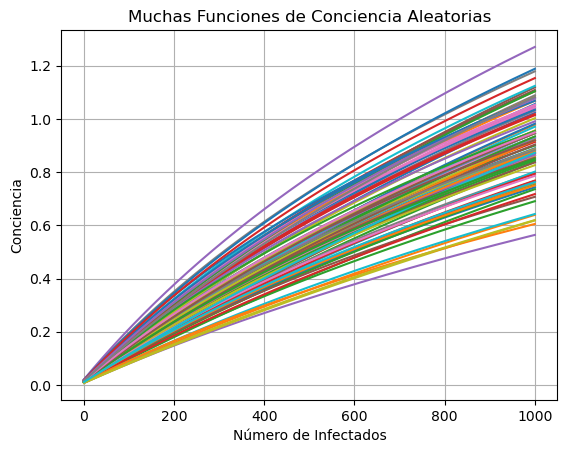

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Graficar varias funciones de conciencia con parámetros obtenidos de sus distribuciones correspondientes
for i in range(100):
    risk_perception = awareness_dists["risk_perception"].rvs() # Obtener un valor para risk_perception
    adjustment_rate = awareness_dists["adjustment_rate"].rvs() # Obtener un valor para adjustment_rate
    max_value = awareness_dists["max_value"].rvs() # Obtener un valor para max_value

    num_infected = np.linspace(0, 1000, 500) # Definir el rango de valores para num_infected
    num_deaths = 10  # Valor fijo para num_deaths
    total_population = 1000  # Valor fijo para total_population

    awareness_values = [awareness_func_raw(infected, num_deaths, total_population, risk_perception, adjustment_rate, max_value) for infected in num_infected]
    plt.plot(num_infected, awareness_values)

plt.title("Muchas Funciones de Conciencia Aleatorias")
plt.xlabel("Número de Infectados")
plt.ylabel("Conciencia")
plt.grid()
plt.show()

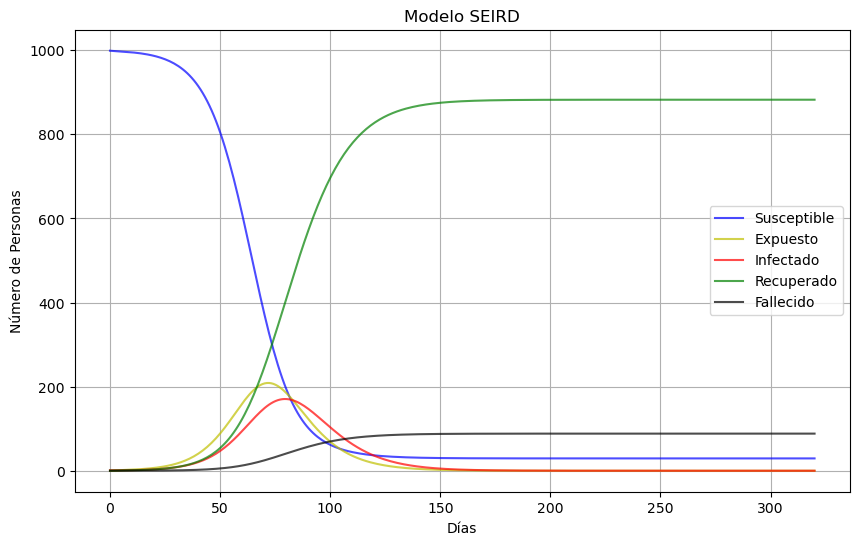

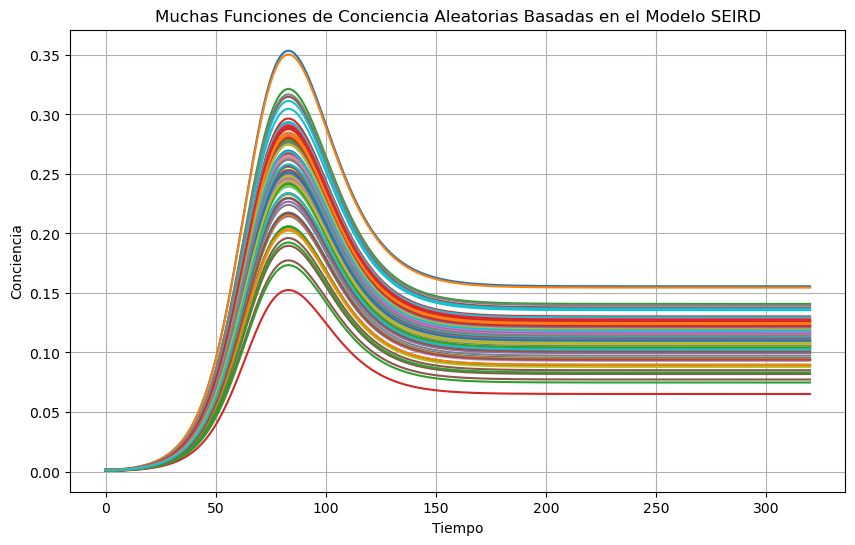

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import truncnorm
from ipywidgets import interact, FloatSlider
import random


# Definir las ecuaciones diferenciales del modelo SEIRD
def seird_model(y, t, beta, gamma, delta, mu, alpha):
    S, E, I, R, D = y
    N = S + E + I + R + D
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

# Parámetros del modelo SEIRD
beta = 0.4   # Tasa de transmisión
gamma = 0.1  # Tasa de recuperación
delta = 0.1  # Tasa de progresión de E a I
mu = 0.01    # Tasa de mortalidad
alpha = 0.1  # Tasa de pérdida de inmunidad

# Condiciones iniciales
S0 = 999  # Población susceptible inicial
E0 = 0    # Población expuesta inicial
I0 = 1    # Población infectada inicial
R0 = 0    # Población recuperada inicial
D0 = 0    # Población fallecida inicial
y0 = [S0, E0, I0, R0, D0]

# Tiempo de simulación
t = np.linspace(0, 320, 320)

# Solucionar el modelo SEIRD
sol = odeint(seird_model, y0, t, args=(beta, gamma, delta, mu, alpha))

# Extraer resultados
S, E, I, R, D = sol.T

plt.figure(figsize=(10, 6))
plt.plot(t, S, 'b', alpha=0.7, label='Susceptible')
plt.plot(t, E, 'y', alpha=0.7, label='Expuesto')
plt.plot(t, I, 'r', alpha=0.7, label='Infectado')
plt.plot(t, R, 'g', alpha=0.7, label='Recuperado')
plt.plot(t, D, 'k', alpha=0.7, label='Fallecido')

plt.title('Modelo SEIRD')
plt.xlabel('Días')
plt.ylabel('Número de Personas')
plt.legend()
plt.grid(True)
plt.show()

def awareness_function(num_infected, num_deaths, total_population, risk_perception=1.0, adjustment_rate=1.0, max_value=0.9):
    if total_population == 0:
        return 0 # Evitar división por cero
    combined_value = (num_infected + num_deaths) * risk_perception
    scaled_value = combined_value / total_population
    awareness = max_value * np.log(1 + scaled_value * adjustment_rate) / np.log(1 + adjustment_rate) # Logarítmica normalizada
    return awareness # Aseguramos que no exceda el valor máximo especificado

def get_var_dist(mean, sd, maxdev):
    minval = mean - maxdev
    maxval = mean + maxdev
    slider = FloatSlider(min=minval, max=maxval, step=(maxval-minval)/20, value=mean)
    dist = truncnorm((minval - mean) / sd, (maxval - mean) / sd, loc=mean, scale=sd)
    return slider, dist

awareness_sliders = {}
awareness_dists = {}
awareness_sliders["risk_perception"], awareness_dists["risk_perception"] = get_var_dist(1.0, 0.1, 0.5)
awareness_sliders["adjustment_rate"], awareness_dists["adjustment_rate"] = get_var_dist(1.0, 0.1, 0.5)
awareness_sliders["max_value"], awareness_dists["max_value"] = get_var_dist(0.9, 0.1, 0.5)

plt.figure(figsize=(10, 6))
# Graficar varias funciones de conciencia con parámetros obtenidos de sus distribuciones correspondientes
for i in range(100):
    risk_perception = awareness_dists["risk_perception"].rvs() # Obtener un valor para risk_perception
    adjustment_rate = awareness_dists["adjustment_rate"].rvs() # Obtener un valor para adjustment_rate
    max_value = awareness_dists["max_value"].rvs() # Obtener un valor para max_value

    awareness_values = [awareness_function(I[j], D[j], S0+E0+I0+R0+D0, risk_perception, adjustment_rate, max_value) for j in range(len(t))]
    plt.plot(t, awareness_values)

plt.title("Muchas Funciones de Conciencia Aleatorias Basadas en el Modelo SEIRD")
plt.xlabel("Tiempo")
plt.ylabel("Conciencia")
plt.grid()
plt.show()





## Agregando nuestras clases

Ahora podemos crear nuestra clase de IA, la clase de persona y clase de entorno y definir cómo se ejecutará la simulación. Luego hacemos que las acciones se lleven a cabo mediante métodos en el entorno, mientras que la clase persona se usa principalmente para contener atributos relacionados.

La clase AIController

In [26]:
class AIController:
    def __init__(self, people, radius, shape, strategy="random", randomness=0.2, tolerance=3, awareness = 0.5, risk_perception=1.0, adjustment_rate=1.0, max_awareness=0.9):
        if strategy in ["random", "social", "awareness"]:
            self.shape = shape
            self.radius = radius
            self.people = people
            self.strategy = strategy
            self.randomness = randomness  # Nivel de aleatoriedad en las decisiones
            self.tolerance = tolerance    # Tolerancia a la proximidad de otras personas
            self.awareness = awareness
            self.risk_perception = risk_perception
            self.adjustment_rate = adjustment_rate
            self.max_awareness = max_awareness
        else:
            raise Exception("La estrategia debe ser \"random\", \"social\" o \"awareness\".")

    def change_strategy(self, strategy):
        if strategy in ["random", "social", "awareness"]:
            self.strategy = strategy
        else:
            raise Exception("La estrategia debe ser \"random\", \"social\" o \"awareness\".")

    def initial_angle(self):
        if self.strategy in ["random", "social", "awareness"]:
            return np.random.uniform(0, 2*np.pi)
        else:
            raise Exception("La estrategia debe ser \"random\", \"social\" o \"awareness\".")

    def decide_angle(self, current_person):
        if self.strategy == "random":
            return current_person.angle + np.random.uniform(-current_person.angle_deviation, current_person.angle_deviation)
        elif self.strategy == "social":
            if current_person.caught_time == None and np.random.random()  < 1-self.randomness:
                return self.decide_angle_cautious(current_person)
            else:
                return self.decide_angle_random(current_person)
        elif self.strategy == "awareness":
            if  1-self.awareness < self.awareness_func():  # Si la conciencia es alta, el agente toma decisiones más cautelosas
                return self.decide_angle_cautious(current_person)
            else:  # Si la conciencia es baja, el agente toma decisiones aleatorias
                return self.decide_angle_random(current_person)
        else:
            raise Exception("La estrategia debe ser \"random\", \"social\" o \"awareness\".")

    def decide_angle_cautious(self, current_person):
        nearby_people = self.find_nearby_people(current_person)
        avoid_people = self.calculate_avoidance_vector(current_person, nearby_people)
        random_angle = np.random.uniform(-np.pi, np.pi)
        angle_to_avoid = np.arctan2(avoid_people[1], avoid_people[0]) + random_angle
        return angle_to_avoid

    def decide_angle_random(self, current_person):
        return current_person.angle + np.random.uniform(-current_person.angle_deviation, current_person.angle_deviation)

    def decide_speed(self, current_person):
        if self.strategy in ["random", "social", "awareness"]:
            return current_person.speed
        else:
            raise Exception("La estrategia debe ser \"random\", \"social\" o \"awareness\".")

    def find_nearby_people(self, current_person):
        nearby_people = []
        for group_name, group in self.people.items():
            for person in group:
                if person is not current_person:
                    distance = np.linalg.norm(np.minimum(np.abs(current_person.location - person.location), self.shape - np.abs(current_person.location - person.location)))
                    if distance <= self.radius:
                        nearby_people.append(person)
        return nearby_people

    def calculate_avoidance_vector(self, current_person, nearby_people):
        avoidance_vector = np.array([0.0, 0.0])
        for person in nearby_people:
            distance = np.linalg.norm(np.minimum(np.abs(current_person.location - person.location), self.shape - np.abs(current_person.location - person.location)))
            if distance < self.tolerance:
                vector_to_person = np.minimum(np.abs(current_person.location - person.location), self.shape - np.abs(current_person.location - person.location))
                vector_to_person /= np.linalg.norm(vector_to_person)  # Normalize
                avoidance_vector -= vector_to_person  # Move in the opposite direction
        return avoidance_vector

    def calculate_avoidance_vector_closer(self, current_person, nearby_people):
        avoidance_vector = np.array([0.0, 0.0])
        min_distance = float('inf')
        closest_person = None

        for person in nearby_people:
            distance = np.linalg.norm(np.minimum(np.abs(current_person.location - person.location), self.shape - np.abs(current_person.location - person.location)))
            if distance < min_distance:
                min_distance = distance
                closest_person = person

        if closest_person and min_distance < self.tolerance:
            vector_to_person = np.minimum(np.abs(current_person.location - closest_person.location), self.shape - np.abs(current_person.location - closest_person.location))
            vector_to_person /= np.linalg.norm(vector_to_person)
            avoidance_vector -= vector_to_person

        return avoidance_vector


    def can_die(self, current_person):
        if self.strategy in ["random", "social", "awareness"]:
            return np.random.random() < current_person.death_prob
        else:
            raise Exception("La estrategia debe ser \"random\", \"social\" o \"awareness\".")

    def can_sick(self, current_person):
        if self.strategy in ["random", "social", "awareness"]:
            return np.random.random() < current_person.exposure_func(current_person.exposure, current_person)
        else:
            raise Exception("La estrategia debe ser \"random\", \"social\" o \"awareness\".")

    def can_increase_exposure(self, current_person):
        if self.strategy == "random":
            return True
        elif self.strategy == "social":
            return not np.random.random()  < 1-self.randomness
        elif self.strategy == "awareness":
            return not 1-self.awareness < self.awareness_func()
            '''if  1-self.awareness < self.awareness_func():  # Si la conciencia es alta, el agente toma decisiones más cautelosas
                return False
            else:  # Si la conciencia es baja, el agente toma decisiones aleatorias
                return True'''
        else:
            raise Exception("La estrategia debe ser \"random\", \"social\" o \"awareness\".")

    def awareness_func(self):
        total_population = len(self.people["I"])+len(self.people["D"])+len(self.people["S"])+len(self.people["R"])
        combined_value = (len(self.people["I"]) + len(self.people["D"])) * self.risk_perception
        if total_population == 0:
            return 0  # Evitar división por cero
        scaled_value = combined_value / total_population
        awareness = self.max_awareness * np.log(1 + scaled_value * self.adjustment_rate) / np.log(1 + self.adjustment_rate)   # Logarítmica normalizada
        return awareness #min(awareness, self.max_awareness)  # Aseguramos que no exceda el valor máximo especificado

La clase Person (persona)

In [27]:
class AIPerson:

    def __init__( self,
                  location,
                  speed,
                  infectivity_params,
                  exposure_params,
                  shape,
                  infectivity_func,
                  distance_func,
                  exposure_func,
                  peak,
                  radius,
                  exposure_decrement,
                  death_prob,
                  immunity_time,
                  ai_controller):

        self.location = location
        self.speed = speed

        self.infectivity_params = infectivity_params
        self.exposure_params = exposure_params

        self.shape = shape
        self.infectivity_func = infectivity_func
        self.distance_func = distance_func
        self.exposure_func = exposure_func
        self.peak = peak
        self.radius = radius
        self.exposure_decrement = exposure_decrement
        self.death_prob = death_prob
        self.immunity_time = immunity_time

        # Asignar el controlador de IA
        self.ai_controller = ai_controller

        self.angle = ai_controller.initial_angle() # Inicializa un ángulo aleatorio en el que la persona se mueve
        self.angle_deviation = .5 # Inicializa la desviación del ángulo a 0,5

        self.exposure = 0 # Inicializa la exposición a 0 (el valor mínimo)
        self.caught_time = None # Inicializa la hora en la que la persona contrajo la enfermedad por última vez en Ninguno
        self.recovered_time = None # Inicializa la hora en la que la persona se recuperó por última vez de la enfermedad en Ninguno

    def move(self):
        # Modificar el ángulo en una cantidad aleatoria a partir de una distribución uniforme
        self.angle = self.ai_controller.decide_angle(self)
        # Calcular el vector de desplazamiento de longitud dado por su velocidad y dirección dada por su ángulo
        self.speed = self.ai_controller.decide_speed(self)
        vector = self.speed*np.array([np.cos(self.angle), np.sin(self.angle)])
        # Actualizar su ubicación, haciendo que se ajusten a los bordes si es necesario
        self.location = np.mod(self.location+vector, self.shape)

    def recover(self, current_time):
        # Marcar la persona como recuperada y restablecer la exposición
        self.recovered_time = current_time
        self.caught_time = None


    def time_since_caught(self, current_time):
        return current_time - self.caught_time # Calcular el tiempo que la persona ha estado infectada

    def infectivity(self, current_time):
        return self.infectivity_func(self.time_since_caught(current_time), self) # Calcular la infectividad de la persona.

    def recovered(self, current_time):
        infectivity = self.infectivity_func(self.time_since_caught(current_time), self) # Calcular la infectividad de la persona.
        # Si la infectividad es baja (y supera el pico), entonces la persona se recupera
        recovered = self.time_since_caught(current_time)>self.peak and infectivity<1
        if (recovered):
            self.recover(current_time)
        return recovered

    def increase_exposure(self, infected, current_time):
        if self.ai_controller.can_increase_exposure(self):
            # Encuentre el vector más corto que conecta a las dos personas (permitido abarcar los bordes)
            vector = np.abs(self.location - infected.location)
            wrapped_vector = np.minimum(vector, self.shape-vector)
            distance = np.linalg.norm(wrapped_vector, ord=2) # Calcular la distancia entre las dos personas.
            # Si la distancia es menor que el radio, aumente la exposición de la persona.
            if distance <= self.radius:
                self.exposure += infected.infectivity(current_time)*self.distance_func(distance)

    def decrease_exposure(self):
        # Disminuir la exposición de la persona (sin bajar de 0)
        self.exposure = max(self.exposure-self.exposure_decrement, 0)

    def infected(self, current_time):
        # Marcar la persona como infectada y registrar el tiempo de infección
        self.caught_time = current_time
        self.recovered_time = None

    def can_die(self):
        return self.ai_controller.can_die(self)

    def can_sick(self):
        return self.ai_controller.can_sick(self)

    def can_susceptible(self, current_time):
        return current_time > self.recovered_time + self.immunity_time

    def susceptible(self):
        self.exposure = 0



La clase Enviroment (Entorno)

In [28]:
class AIEnvironment:

    def __init__(self,
                 infectivity_func=infectivity_func,
                 distance_func=distance_func,
                 exposure_func=exposure_func,
                 infectivity_dists=infectivity_dists,
                 exposure_dists=exposure_dists,
                 radius=8,
                 shape=np.array([100,100]),
                 speed=1,
                 immunity_time=60,
                 exposure_decrement=15,
                 permanent_immunity=True,
                 peak = 40,
                 is_death=False,
                 death_prob=0.0002,
                 ai_strategy="social"):


        self.infectivity_func=infectivity_func
        self.distance_func=distance_func
        self.exposure_func=exposure_func
        self.infectivity_dists=infectivity_dists
        self.exposure_dists=exposure_dists
        self.radius=radius
        self.shape=shape
        self.speed=speed
        self.immunity_time=immunity_time
        self.exposure_decrement=exposure_decrement
        self.permanent_immunity=permanent_immunity
        self.peak = peak
        self.is_death=is_death
        self.death_prob=death_prob

        self.people = {"S": [], "I": [], "R": [], "D": []} # Inicializar un diccionario para alojar a las agentes por grupo.
        self.time = 0 # Inicializar el tiempo a 0

        self.ai_controller = AIController(self.people, self.radius, self.shape, strategy="random", randomness=0.1, tolerance=3, awareness = 0.5, risk_perception=1.0, adjustment_rate=1.0, max_awareness=0.9)

    def gen_location(self):
        return np.random.uniform(self.shape)

    def gen_params(self):
        # Inicializar el diccionario de parámetros para la función de infectividad mediante la comprensión del diccionario
        infectivity_params = {key:dist.rvs() for key,dist in infectivity_dists.items()}
        # Inicializar el diccionario de parámetros para la función de exposición mediante comprensión del diccionario.
        exposure_params = {key:dist.rvs() for key,dist in exposure_dists.items()}
        return {"infectivity_params": infectivity_params, "exposure_params": exposure_params}

    def add_person(self, group="S", person = None):
        # Inicialice a la persona con una ubicación aleatoria, la velocidad especificada en el entorno y una ubicación aleatoria.
        # parámetros para las funciones de infectividad y exposicióninfectivity_params,

        if person == None:
            person = AIPerson(location = self.gen_location(),
                            speed = self.speed,
                            infectivity_params = self.gen_params()["infectivity_params"],
                            exposure_params = self.gen_params()["exposure_params"],
                            shape = self.shape,
                            infectivity_func = self.infectivity_func,
                            distance_func = self.distance_func,
                            exposure_func = self.exposure_func,
                            peak = self.peak,
                            radius = self.radius,
                            exposure_decrement = self.exposure_decrement,
                            death_prob = self.death_prob,
                            immunity_time = self.immunity_time,
                            ai_controller=self.ai_controller)

        # Inicializa caught_time y recovered_time a 0 si es necesario
        if group=="I":
            person.infected(self.time)
        elif group=="R":
            person.recover()
        self.people[group].append(person) # Agrega a la persona a la lista correspondiente.

    def move_all(self):
         for group in self.people.values(): # Recorre todos los grupos de personas.
            for person in group: # Recorre las personas dentro de cada grupo.
                person.move()

    def infected_actions(self):
        # Recorra la lista de personas infectadas por índice a la inversa (ya que la lista puede modificarse)
        idx = len(self.people["I"])-1
        while idx >= 0:
            infected = self.people["I"][idx] # Acceder a la persona en el índice actual
            if infected.recovered(self.time):
                del self.people["I"][idx] # Eliminar a la persona de la lista de infectados
                self.people["R"].append(infected) # Agregar a la persona a la lista recuperada
            else:
                for person in self.people["S"]: # Recorrer todos los agentes susceptibles
                    person.increase_exposure(infected, self.time)
            # Si la muerte es un factor en el modelo, use un número aleatorio para ver si la persona muere
            if self.is_death and infected.can_die():
                del self.people["I"][idx] # Eliminar a la persona de la lista de infectados
                self.people["D"].append(infected) # Agregar la persona a la lista de muertos
            idx -= 1 # Disminuir el índice

    def susceptible_actions(self):
        # Recorra la lista de personas susceptibles por índice a la inversa (ya que la lista puede modificarse)
        idx = len(self.people["S"])-1
        while idx >= 0:
            susceptible = self.people["S"][idx] # Accede a la persona en el índice actual
            # Comprobar si la persona contrae la enfermedad utilizando la función de exposición.
            if susceptible.can_sick():
                del self.people["S"][idx] # Eliminar a la persona de la lista de susceptibles
                self.people["I"].append(susceptible) # Agregar la persona a la lista de infectados
                susceptible.infected(self.time)
            else:
                # Disminuir la exposición de la persona (sin bajar de 0)
                susceptible.decrease_exposure()
            idx -= 1 # Disminuir el índice

    def recovered_actions(self):
        # Se ejecuta el siguiente código solo si es posible volver a contraer la enfermedad
        if not self.permanent_immunity:
            # Recorra la lista de personas recuperadas por índice a la inversa (ya que la lista puede modificarse)
            idx = len(self.people["R"])-1
            while idx>= 0:
                recovered = self.people["R"][idx] # Acceder a la persona en el índice actual
                # Se comprueba si la inmunidad de la persona recuperada ha finalizado
                if recovered.can_susceptible(self.time):
                    del self.people["R"][idx] # Eliminar a la persona de la lista recuperada
                    self.people["S"].append(recovered) # Agregar la persona a la lista de susceptibles
                    recovered.susceptible()
                idx -= 1 # Disminuir el índice

    def get_location_arrays(self):
        return [np.array([person.location for person in group]) for group_name, group in self.people.items() if group_name != "D"]

    def advance_time(self):
        self.time += 1 # Incrementar el tiempo
        self.move_all() # Mover a todos los agentes

        self.infected_actions() # Realizar acciones a infectados
        self.susceptible_actions() # Realizar acciones a susceptibles
        self.recovered_actions() # Realizar acciones a recuperados

        return self.get_location_arrays()

El siguiente código ejecuta el modelo y grafica el resultado.

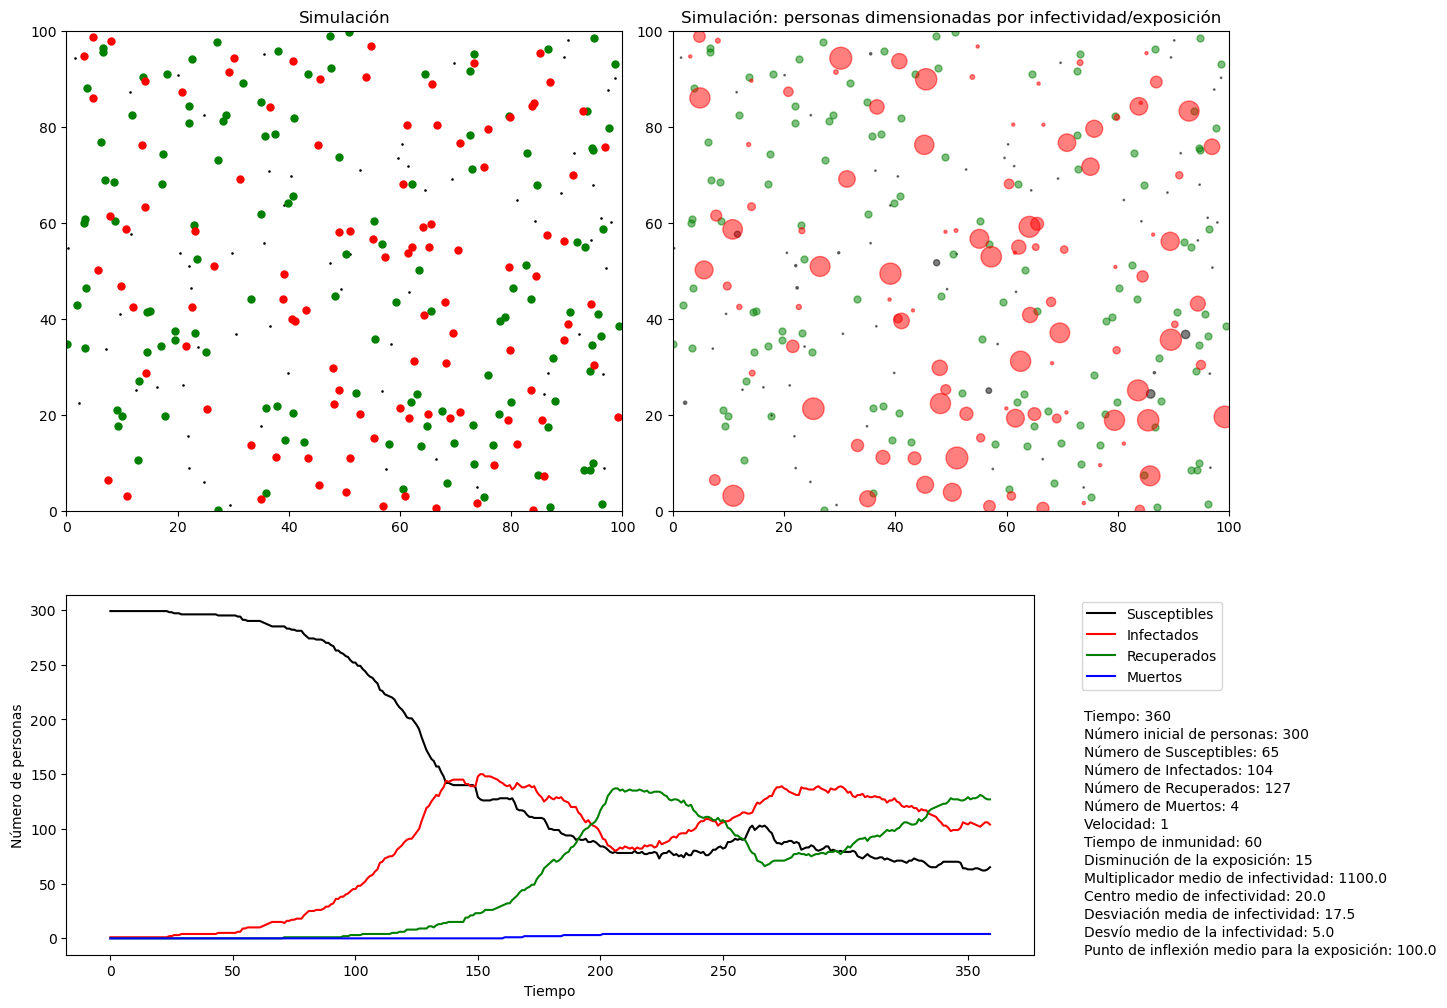

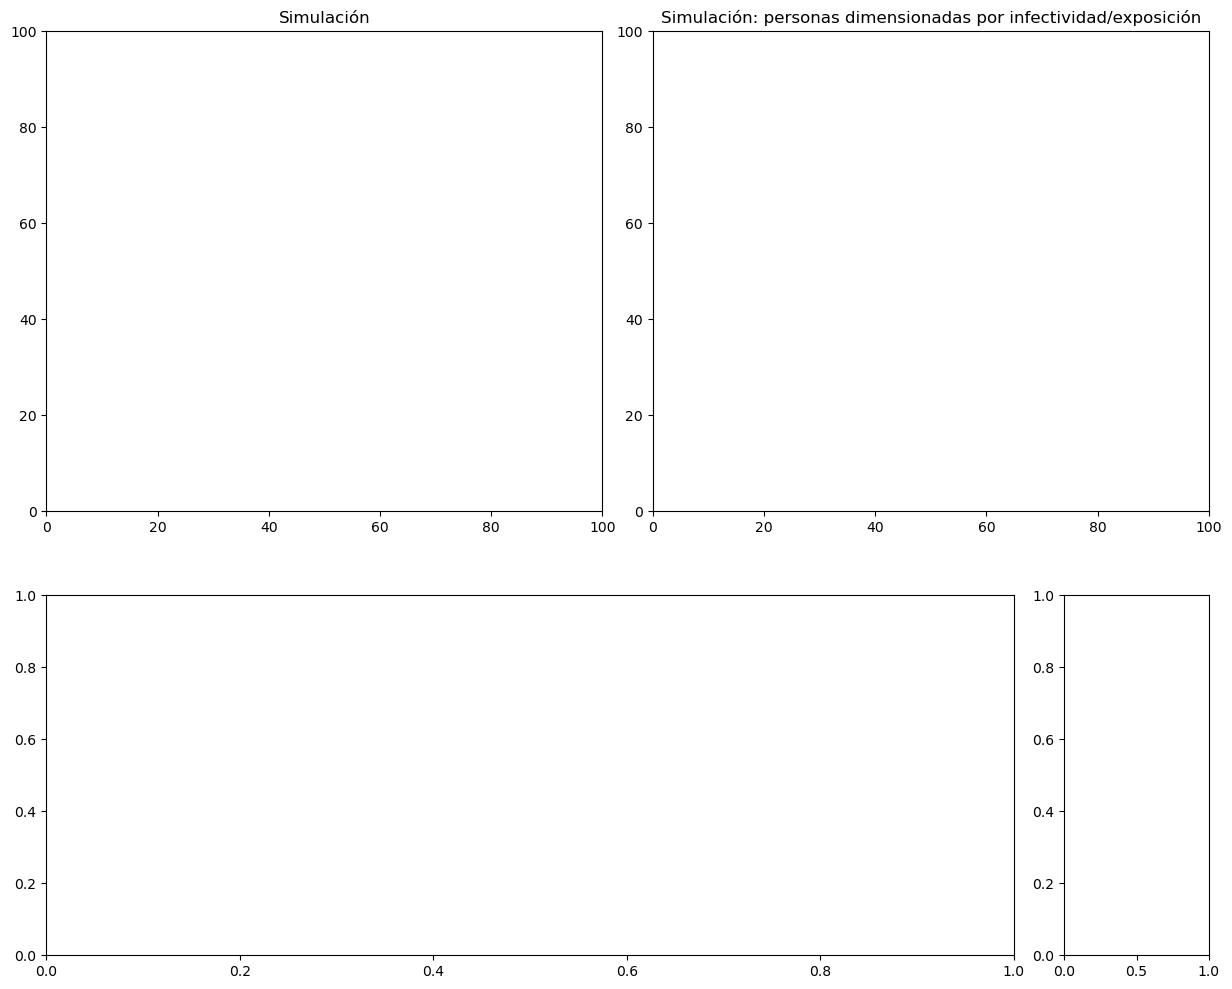

In [29]:
import time

np.random.seed(31415) # Establecer una semilla aleatoria para la reproducibilidad

# Inicializar el entorno
env = AIEnvironment(permanent_immunity=False, exposure_decrement=15, is_death=True)
env.ai_controller = AIController(env.people, env.radius, env.shape, strategy="awareness", randomness=0.8, tolerance=3, awareness = 0.5, risk_perception=1.0, adjustment_rate=1.0, max_awareness=0.9)

# Agregar agentes susceptibles
for _ in range(299):
    env.add_person()

# Agregar un agente infectado
env.add_person("I")

fig = plt.figure(figsize=(15,12)) # Inicializar una figura
gs = GridSpec(2,4, figure=fig, height_ratios=[4,3], width_ratios=[5,2,5,2]) # Especificar las subtramas con GridSpec
ax_sim1 = fig.add_subplot(gs[0,:2]) # Inicializar el panel de simulación principal
# Establecer los límites en el panel principal de simulación
ax_sim1.set_xlim(0,env.shape[0])
ax_sim1.set_ylim(0,env.shape[1])

ax_sim2 = fig.add_subplot(gs[0,2:]) # Inicializar el panel de simulación secundario
# Establecer los límites en el panel de simulación secundario
ax_sim2.set_xlim(0,env.shape[0])
ax_sim2.set_ylim(0,env.shape[1])

ax_infected = fig.add_subplot(gs[1,:-1]) # Inicialice un conjunto de ejes para un gráfico de líneas del tamaño de los grupos.
ax_info = fig.add_subplot(gs[1,-1]) # Inicializar un conjunto de ejes para información textual.

# Inicializar listas para contener la cantidad de personas en cada grupo en cada momento
num_s = []
num_i = []
num_r = []
num_d = []

start_time = time.time()

#env.ai_controller.change_strategy("awareness")

num_days = 360


for day in range(num_days):


    S_locs, I_locs, R_locs = env.advance_time() # Avanzar el tiempo y almacenar las ubicaciones de cada grupo
    # Corregir las dimensiones de los arrays en el caso de que un grupo esté vacío
    if not S_locs.size:
        S_locs = np.empty(shape=(0,2))
    if not I_locs.size:
        I_locs = np.empty(shape=(0,2))
    if not R_locs.size:
        R_locs = np.empty(shape=(0,2))

    S_plot1 = ax_sim1.scatter(*S_locs.T, c="k", marker=".", s=3) # Mostrar la población susceptible en negro.
    R_plot1 = ax_sim1.scatter(*R_locs.T, c="g", marker=".", s=100) # Mostrar en verde la población recuperada.
    I_plot1 = ax_sim1.scatter(*I_locs.T, marker=".", s=100, c="r") # Mostrar en rojo la población infestada.

    ax_sim1.set_title("Simulación") # Establecer el título del panel de simulación principal

    # Inicialice una lista que represente el tamaño de cada persona infectada (según su infectividad)
    I_size = np.array([env.infectivity_func(env.time - person.caught_time, person) for person in env.people["I"]])+1
    # Inicializar una lista que represente el tamaño de cada persona susceptible (según su exposición)
    S_size = np.array([person.exposure for person in env.people["S"]])+2
    S_plot2 = ax_sim2.scatter(*S_locs.T, c="k", marker=".", s=S_size*2, alpha=.5) # Plot la población susceptible
    R_plot2 = ax_sim2.scatter(*R_locs.T, c="g", marker=".", s=100, alpha=.5) # Plot la poblacion recuperada
    I_plot2 = ax_sim2.scatter(*I_locs.T, marker=".", s=I_size*20, c="r", alpha=.5) # Plot la población infectada

    ax_sim2.set_title("Simulación: personas dimensionadas por infectividad/exposición") # Establecer el título del panel de simulación secundario

    # Actualizar las listas con el tamaño actual de cada grupo.
    num_s.append(len(env.people["S"]))
    num_i.append(len(env.people["I"]))
    num_r.append(len(env.people["R"]))
    num_d.append(len(env.people["D"]))

    ax_infected.plot(num_s, color="k", label="Susceptibles") # Plot el número de personas susceptibles a lo largo del tiempo
    ax_infected.plot(num_i, color="r", label="Infectados") # Plot el número de personas infectadas a lo largo del tiempo
    ax_infected.plot(num_r, color="g", label="Recuperados") # Plot el número de personas recuperadas a lo largo del tiempo
    if env.is_death:
        ax_infected.plot(num_d, color="b", label="Muertos") # Plot el número de muertos a lo largo del tiempo

    ax_infected.set_xlabel("Tiempo") # Establecer la etiqueta x del gráfico lineal
    ax_infected.set_ylabel("Número de personas") # Establecer la etiqueta y del gráfico lineal

    ax_info.legend(*ax_infected.get_legend_handles_labels()) # Agregar una leyenda (en una subtrama diferente, de ahí el argumento)
    ax_info.axis('off') # Eliminar los ejes de la subtrama de texto.

    if env.is_death: # Mostrar texto en el caso de que la muerte sea parte del modelo.
        ax_info.text(0,.65,"Tiempo: "+str(env.time),size=10)
        ax_info.text(0,.6,"Número inicial de personas: "+str(num_s[-1]+num_i[-1]+num_r[-1]+num_d[-1]),size=10)
        ax_info.text(0,.55,"Número de Susceptibles: "+str(num_s[-1]),size=10)
        ax_info.text(0,.5,"Número de Infectados: "+str(num_i[-1]),size=10)
        ax_info.text(0,.45,"Número de Recuperados: "+str(num_r[-1]),size=10)
        ax_info.text(0,.4,"Número de Muertos: "+str(num_d[-1]),size=10)
        ax_info.text(0,.35,"Velocidad: "+str(env.speed),size=10)
        ax_info.text(0,.3,"Tiempo de inmunidad: "+("inf" if env.permanent_immunity else str(env.immunity_time)),size=10)
        ax_info.text(0,.25,"Disminución de la exposición: "+str(env.exposure_decrement),size=10)
        ax_info.text(0,.2,"Multiplicador medio de infectividad: "+str(env.infectivity_dists["a"].mean()),size=10)
        ax_info.text(0,.15,"Centro medio de infectividad: "+str(env.infectivity_dists["m"].mean()),size=10)
        ax_info.text(0,.1,"Desviación media de infectividad: "+str(env.infectivity_dists["s"].mean()),size=10)
        ax_info.text(0,.05,"Desvío medio de la infectividad: "+str(env.infectivity_dists["k"].mean()),size=10)
        ax_info.text(0,.0,"Punto de inflexión medio para la exposición: "+str(env.exposure_dists["s"].mean()),size=10)
    else: # Mostrar texto en el caso de que la muerte no sea parte del modelo.
        ax_info.text(0,.7,"Tiempo: "+str(env.time),size=10)
        ax_info.text(0,.65,"Total de personas: "+str(num_s[-1]+num_i[-1]+num_r[-1]),size=10)
        ax_info.text(0,.6,"Número de Susceptibles: "+str(num_s[-1]),size=10)
        ax_info.text(0,.55,"Número de Infectados: "+str(num_i[-1]),size=10)
        ax_info.text(0,.5,"Número de Recuperados: "+str(num_r[-1]),size=10)
        ax_info.text(0,.45,"Velocidad: "+str(env.speed),size=10)
        ax_info.text(0,.4,"Tiempo de inmunidad: "+("inf" if env.permanent_immunity else str(env.immunity_time)),size=10)
        ax_info.text(0,.35,"Disminución de la exposición: "+str(env.exposure_decrement),size=10)
        ax_info.text(0,.3,"Multiplicador medio de infectividad: "+str(env.infectivity_dists["a"].mean()),size=10)
        ax_info.text(0,.25,"Centro medio de infectividad: "+str(env.infectivity_dists["m"].mean()),size=10)
        ax_info.text(0,.2,"Desviación media de infectividad: "+str(env.infectivity_dists["s"].mean()),size=10)
        ax_info.text(0,.15,"Desvío medio de la infectividad: "+str(env.infectivity_dists["k"].mean()),size=10)
        ax_info.text(0,.1,"Punto de inflexión medio para la exposición: "+str(env.exposure_dists["s"].mean()),size=10)

    clear_output(wait=True) # Borrar la salida
    display(fig) # Mostrar el modelo
    #plt.savefig("output/output"+str(env.time)) # Guarde el gráfico en la carpeta "output"
    I_plot1.remove() # Eliminar agentes infectados de la simulación principal.
    S_plot1.remove() # Eliminar agentes susceptibles de la simulación principal.
    R_plot1.remove() # Eliminar agentes recuperados de la simulación principal.
    I_plot2.remove() # Eliminar agentes infectados de la simulación secundaria.
    S_plot2.remove() # Eliminar agentes susceptibles de la simulación secundaria.
    R_plot2.remove() # Eliminar agentes recuperados de la simulación secundaria.
    ax_infected.cla() # Limpiar el plot de líneas
    ax_info.cla() # Borrar el texto informativo

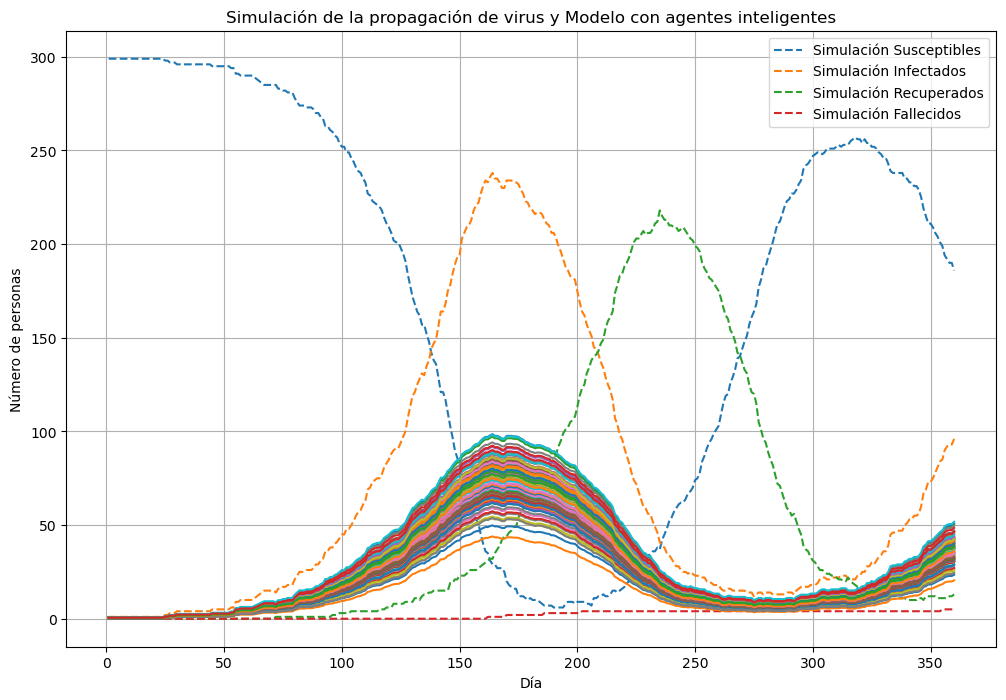

In [31]:
import time
import numpy as np
from scipy.stats import norm  # Utilizado para generar distribuciones normales truncadas

# Función de Conciencia modificada con parámetros personalizados
def awareness_function(num_infected, num_deaths, total_population, risk_perception=1.0, adjustment_rate=1.0, max_value=0.9):
    if total_population == 0:
        return 0  # Evitar división por cero
    combined_value = (num_infected + num_deaths) * risk_perception
    scaled_value = combined_value / total_population
    awareness = max_value * np.log(1 + scaled_value * adjustment_rate) / np.log(1 + adjustment_rate)  # Logarítmica normalizada
    return awareness#min(awareness, max_value)  # Aseguramos que no exceda el valor máximo especificado

risk_perception_dist = norm(loc=1.0, scale=0.2)
adjustment_rate_dist = norm(loc=1.0, scale=0.2)


# Obtener valores para los parámetros personalizados de la función de conciencia
risk_perception = risk_perception_dist.rvs(size = 100)
adjustment_rate = adjustment_rate_dist.rvs(size = 100)

np.random.seed(31415) # Establecer una semilla aleatoria para la reproducibilidad

# Inicializar el entorno
env = AIEnvironment(permanent_immunity=False, exposure_decrement=15, is_death=True)


# Agregar agentes susceptibles
for _ in range(299):
    env.add_person()


# Agregar un agente infectado
env.add_person("I")


days = []
susceptible_counts = []
infected_counts = []
recovered_counts = []
dead_counts = []
awareness = []


num_days = 360
env.ai_controller.change_strategy("random")


# Simular la propagación de la epidemia
for day in range(num_days):  # Simulación de 100 días
    env.advance_time()
    # Registrar estadísticas diarias
    days.append(env.time)
    susceptible_counts.append(len(env.people["S"]))
    infected_counts.append(len(env.people["I"]))
    recovered_counts.append(len(env.people["R"]))
    dead_counts.append(len(env.people["D"]))

#t = np.linspace(0, num_days, num_days)

# Visualizar los resultados
plt.figure(figsize=(12, 8))
plt.plot(days, susceptible_counts, label='Simulación Susceptibles', linestyle='--')
plt.plot(days, infected_counts, label='Simulación Infectados', linestyle='--')
plt.plot(days, recovered_counts, label='Simulación Recuperados', linestyle='--')
plt.plot(days, dead_counts, label='Simulación Fallecidos', linestyle='--')
for rp, ar in zip(risk_perception, adjustment_rate):
    awareness = []
    for day in range(num_days):
        awareness.append(awareness_function(infected_counts[day], dead_counts[day], 300, risk_perception=rp , adjustment_rate=ar , max_value = 0.9) * 100)
    plt.plot(days, awareness)



plt.xlabel('Día')
plt.ylabel('Número de personas')
plt.title('Simulación de la propagación de virus y Modelo con agentes inteligentes')
plt.legend()
plt.grid(True)
plt.show()